# Investment Research Agent - Multi-Agent System

## Project Overview
This notebook implements an autonomous Investment Research Agent that demonstrates:

## Architecture
- **Multi-Agent System**: Coordinator, Specialist Agents (News, Technical, Fundamental)
- **Memory System**: FAISS vector database for persistent learning
- **Data Sources**: Yahoo Finance, NewsAPI, FRED, Alpha Vantage
- **Interface**: Gradio web interface for user interaction

## 1. Environment Setup and Dependencies

In [14]:
# Install required packages
!pip install langchain langchain-openai langchain-community yfinance pandas numpy matplotlib seaborn plotly gradio faiss-cpu python-dotenv requests fredapi newsapi-python chromadb

In [15]:
# Core Python Libraries
import os
import json
import warnings
import logging
import time
import ssl
import urllib3
import contextlib
import traceback
import io
from typing import Dict, List, Any, Optional
from datetime import datetime, timedelta

# Data Analysis and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Environment and Configuration
from dotenv import load_dotenv

# LangChain Core
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.tools import BaseTool, tool
from langchain.memory import ConversationBufferWindowMemory
from langchain.schema import BaseMessage, HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.docstore.document import Document

# LangChain Azure OpenAI
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

# LangChain Community (Vector Store)
from langchain_community.vectorstores import FAISS

# External Data Sources
import yfinance as yf
from newsapi import NewsApiClient
from fredapi import Fred

# Web Interface
import gradio as gr

# Jupyter/IPython Display
from IPython.display import display, Markdown, HTML, Image

# HTTP Clients
import requests
import requests.sessions

# Load environment variables
load_dotenv()

# Configure Matplotlib for Proper Display
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configure logging for clean output
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

# Suppress verbose logging from external libraries
external_loggers = [
    "httpx",
    "azure.core.pipeline.policies.http_logging_policy", 
    "azure.identity",
    "urllib3"
]

for logger_name in external_loggers:
    logging.getLogger(logger_name).setLevel(logging.WARNING)

@contextlib.contextmanager
def suppress_llm_logs():
    """Context manager to suppress verbose LLM logging during execution"""
    original_levels = {}
    
    # Store original log levels
    for logger_name in external_loggers:
        logger = logging.getLogger(logger_name)
        original_levels[logger_name] = logger.level
        logger.setLevel(logging.WARNING)
    
    try:
        yield
    finally:
        # Restore original levels
        for logger_name, level in original_levels.items():
            logging.getLogger(logger_name).setLevel(level)

print("All libraries imported successfully!")


All libraries imported successfully!


In [16]:
# Configuration from environment variables
AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_OPENAI_ENDPOINT = os.getenv('AZURE_OPENAI_ENDPOINT')
AZURE_OPENAI_GPT_DEPLOYMENT_NAME = os.getenv('AZURE_OPENAI_GPT_DEPLOYMENT_NAME')
AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv('AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME')
AZURE_OPENAI_GPT_API_VERSION = os.getenv('AZURE_OPENAI_GPT_API_VERSION', '2024-02-15-preview')
AZURE_OPENAI_API_VERSION = os.getenv('AZURE_OPENAI_API_VERSION', '2024-02-15-preview')
AZURE_OPENAI_EMBEDDING_API_VERSION = os.getenv('AZURE_OPENAI_EMBEDDING_API_VERSION', '2024-02-15-preview')

ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
NEWS_API_KEY = os.getenv('NEWSAPI_KEY')
FRED_API_KEY = os.getenv('FRED_API_KEY')
SEC_API_KEY = os.getenv('SEC_API_KEY')  # Optional: For enhanced SEC API access or third-party SEC services

# Initialize Azure OpenAI
llm = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment=AZURE_OPENAI_GPT_DEPLOYMENT_NAME,
    openai_api_version=AZURE_OPENAI_GPT_API_VERSION,
    openai_api_key=AZURE_OPENAI_API_KEY
)

# Initialize embeddings for vector database
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
    openai_api_version=AZURE_OPENAI_EMBEDDING_API_VERSION,
    openai_api_key=AZURE_OPENAI_API_KEY
)

print("Environment setup completed successfully!")

Environment setup completed successfully!


## 2. Vector Database and Memory System

In [17]:
class AgentMemory:
    """persistent memory system using FAISS vector database with intelligent caching."""
    
    def __init__(self, memory_path: str = "./database/agent_memory"):
        self.memory_path = memory_path
        self.vector_store = None
        self.data_cache = {}  # In-memory cache for quick lookups
        self.cache_expiry = 3600  # 1 hour cache expiry for data
        self.analysis_cache_expiry = 7200  # 2 hours for analysis results
        self.initialize_memory()
    
    def initialize_memory(self):
        """Initialize or load existing memory."""
        try:
            # Try to load existing memory
            if os.path.exists(f"{self.memory_path}.faiss"):
                self.vector_store = FAISS.load_local(self.memory_path, embeddings)
                print("Loaded existing agent memory with cached data")
            else:
                # Create new memory with initial documents
                initial_docs = [
                    Document(page_content="Investment analysis requires considering multiple factors: technical indicators, fundamental analysis, market sentiment, and economic conditions.", 
                            metadata={"type": "general_knowledge", "timestamp": datetime.now().isoformat()})
                ]
                self.vector_store = FAISS.from_documents(initial_docs, embeddings)
                self.save_memory()
                print("Created new agent memory with caching enabled")
        except Exception as e:
            print(f"Error initializing memory: {e}")
            # Fallback: create minimal memory
            initial_docs = [
                Document(page_content="Fallback memory initialized", 
                        metadata={"type": "system", "timestamp": datetime.now().isoformat()})
            ]
            self.vector_store = FAISS.from_documents(initial_docs, embeddings)
    
    def _generate_cache_key(self, data_type: str, symbol: str, **params) -> str:
        """Generate a unique cache key for data requests."""
        # Create a consistent key from parameters
        param_str = "_".join([f"{k}_{v}" for k, v in sorted(params.items())])
        return f"{data_type}_{symbol}_{param_str}".lower()
    
    def _is_cache_valid(self, timestamp_str: str, cache_type: str = "data") -> bool:
        """Check if cached data is still valid."""
        try:
            cache_time = datetime.fromisoformat(timestamp_str)
            current_time = datetime.now()
            expiry_time = self.cache_expiry if cache_type == "data" else self.analysis_cache_expiry
            return (current_time - cache_time).total_seconds() < expiry_time
        except:
            return False
    
    def get_cached_data(self, data_type: str, symbol: str, **params) -> Optional[str]:
        """Retrieve cached data if available and valid."""
        try:
            cache_key = self._generate_cache_key(data_type, symbol, **params)
            
            # First check in-memory cache
            if cache_key in self.data_cache:
                cache_entry = self.data_cache[cache_key]
                if self._is_cache_valid(cache_entry['timestamp']):
                    print(f"Using cached {data_type} data for {symbol}")
                    return cache_entry['data']
                else:
                    # Remove expired cache
                    del self.data_cache[cache_key]
            
            # Search vector database for cached results
            search_query = f"{data_type} data for {symbol} {' '.join(str(v) for v in params.values())}"
            memories = self.vector_store.similarity_search(search_query, k=3)
            
            for memory in memories:
                metadata = memory.metadata
                if (metadata.get('type') == 'cached_data' and 
                    metadata.get('data_type') == data_type and 
                    metadata.get('symbol', '').lower() == symbol.lower() and
                    metadata.get('cache_key') == cache_key):
                    
                    if self._is_cache_valid(metadata.get('timestamp', ''), 'data'):
                        # Cache in memory for faster future access
                        self.data_cache[cache_key] = {
                            'data': memory.page_content,
                            'timestamp': metadata['timestamp']
                        }
                        print(f"Retrieved cached {data_type} data for {symbol} from vector DB")
                        return memory.page_content
            
            return None
        except Exception as e:
            print(f"Error retrieving cached data: {e}")
            return None
    
    def cache_data(self, data_type: str, symbol: str, data: str, **params):
        """Cache data in both memory and vector database."""
        try:
            cache_key = self._generate_cache_key(data_type, symbol, **params)
            timestamp = datetime.now().isoformat()
            
            # Store in memory cache
            self.data_cache[cache_key] = {
                'data': data,
                'timestamp': timestamp
            }
            
            # Store in vector database
            metadata = {
                'type': 'cached_data',
                'data_type': data_type,
                'symbol': symbol,
                'cache_key': cache_key,
                'timestamp': timestamp,
                **{f"param_{k}": str(v) for k, v in params.items()}
            }
            
            doc = Document(page_content=data, metadata=metadata)
            self.vector_store.add_documents([doc])
            self.save_memory()
            
            print(f"Cached {data_type} data for {symbol}")
        except Exception as e:
            print(f"Error caching data: {e}")
    
    def get_cached_analysis(self, analysis_type: str, symbol: str, request_hash: str) -> Optional[Dict[str, Any]]:
        """Retrieve cached analysis results."""
        try:
            search_query = f"{analysis_type} analysis for {symbol}"
            memories = self.vector_store.similarity_search(search_query, k=5)
            
            for memory in memories:
                metadata = memory.metadata
                if (metadata.get('type') == 'cached_analysis' and 
                    metadata.get('analysis_type') == analysis_type and 
                    metadata.get('symbol', '').lower() == symbol.lower() and
                    metadata.get('request_hash') == request_hash):
                    
                    if self._is_cache_valid(metadata.get('timestamp', ''), 'analysis'):
                        try:
                            cached_result = json.loads(memory.page_content)
                            print(f"Using cached {analysis_type} analysis for {symbol}")
                            return cached_result
                        except json.JSONDecodeError:
                            continue
            
            return None
        except Exception as e:
            print(f"Error retrieving cached analysis: {e}")
            return None
    
    def cache_analysis(self, analysis_type: str, symbol: str, analysis_result: Dict[str, Any], request_hash: str):
        """Cache analysis results."""
        try:
            metadata = {
                'type': 'cached_analysis',
                'analysis_type': analysis_type,
                'symbol': symbol,
                'request_hash': request_hash,
                'timestamp': datetime.now().isoformat(),
                'execution_time': analysis_result.get('execution_time', 0)
            }
            
            doc = Document(page_content=json.dumps(analysis_result), metadata=metadata)
            self.vector_store.add_documents([doc])
            self.save_memory()

            print(f"Cached {analysis_type} analysis for {symbol}")
        except Exception as e:
            print(f"Error caching analysis: {e}")
    
    def add_memory(self, content: str, metadata: Dict[str, Any]):
        """Add new memory to the vector store."""
        try:
            doc = Document(page_content=content, metadata=metadata)
            self.vector_store.add_documents([doc])
            self.save_memory()
        except Exception as e:
            print(f"Error adding memory: {e}")
    
    def search_memory(self, query: str, k: int = 5) -> List[Document]:
        """Search for relevant memories."""
        try:
            return self.vector_store.similarity_search(query, k=k)
        except Exception as e:
            print(f"Error searching memory: {e}")
            return []
    
    def cleanup_expired_cache(self):
        """Clean up expired cache entries from memory."""
        try:
            current_time = datetime.now()
            expired_keys = []
            
            for key, entry in self.data_cache.items():
                if not self._is_cache_valid(entry['timestamp']):
                    expired_keys.append(key)
            
            for key in expired_keys:
                del self.data_cache[key]
            
            if expired_keys:
                print(f"Cleaned up {len(expired_keys)} expired cache entries")
        except Exception as e:
            print(f"Error cleaning cache: {e}")
    
    def get_cache_stats(self) -> Dict[str, Any]:
        """Get cache statistics."""
        try:
            memories = self.vector_store.similarity_search("cached", k=100)
            cached_data_count = sum(1 for m in memories if m.metadata.get('type') == 'cached_data')
            cached_analysis_count = sum(1 for m in memories if m.metadata.get('type') == 'cached_analysis')
            
            return {
                'in_memory_cache_size': len(self.data_cache),
                'vector_db_cached_data': cached_data_count,
                'vector_db_cached_analyses': cached_analysis_count,
                'total_memories': len(memories)
            }
        except Exception as e:
            print(f"Error getting cache stats: {e}")
            return {}
    
    def save_memory(self):
        """Save memory to disk."""
        try:
            self.vector_store.save_local(self.memory_path)
        except Exception as e:
            print(f"Error saving memory: {e}")

# Initialize global memory
agent_memory = AgentMemory()
print("Agent memory system initialized!")

Created new agent memory with caching enabled
Agent memory system initialized!


## 3. Data Source Tools and Integrations

In [18]:
# Yahoo Finance Tool with Caching
@tool
def get_stock_data(symbol: str, period: str = "1y") -> str:
    """Get stock price data and basic financial information from Yahoo Finance.
    
    Args:
        symbol: Stock symbol (e.g., 'AAPL', 'MSFT')
        period: Time period ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    """
    try:
        # Check cache first
        cached_data = agent_memory.get_cached_data('stock_data', symbol, period=period)
        if cached_data:
            return cached_data
        
        # Fetch fresh data if not cached
        stock = yf.Ticker(symbol)
        hist = stock.history(period=period)
        info = stock.info
        
        # Check if we have sufficient data
        if hist.empty or len(hist) < 2:
            return f"Error: Insufficient price data for {symbol}"
        
        current_price = hist['Close'].iloc[-1]
        price_change = hist['Close'].iloc[-1] - hist['Close'].iloc[-2]
        price_change_pct = (price_change / hist['Close'].iloc[-2]) * 100
        
        # Convert pandas/numpy types to native Python types for JSON serialization
        result = {
            'symbol': symbol,
            'current_price': float(round(current_price, 2)),
            'price_change': float(round(price_change, 2)),
            'price_change_pct': float(round(price_change_pct, 2)),
            'volume': int(hist['Volume'].iloc[-1]) if pd.notna(hist['Volume'].iloc[-1]) else 0,
            'market_cap': info.get('marketCap', 'N/A'),
            'pe_ratio': info.get('trailingPE', 'N/A'),
            'company_name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            # Add historical price data for technical analysis (last 50 days)
            'price_history': [float(price) for price in hist['Close'].tail(50).tolist()],
            'volume_history': [int(vol) if pd.notna(vol) else 0 for vol in hist['Volume'].tail(50).tolist()],
            'high_52_week': float(hist['High'].max()),
            'low_52_week': float(hist['Low'].min()),
            'avg_volume': int(hist['Volume'].mean()) if not hist['Volume'].isna().all() else 0
        }
        
        result_json = json.dumps(result, indent=2)
        
        # Cache the result
        agent_memory.cache_data('stock_data', symbol, result_json, period=period)
        
        return result_json
    
    except Exception as e:
        return f"Error fetching stock data for {symbol}: {str(e)}"

# News API Tool with Caching
@tool
def get_stock_news(symbol: str, days: int = 7) -> str:
    """Get recent news articles related to a stock symbol.
    
    Args:
        symbol: Stock symbol to search news for
        days: Number of days to look back for news
    """
    try:
        # Check cache first (with shorter cache time for news)
        cached_data = agent_memory.get_cached_data('stock_news', symbol, days=days)
        if cached_data:
            return cached_data
        
        # Configure SSL handling for NewsAPI
        # Disable SSL warnings and verification for NewsAPI (development/testing only)
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
        
        # Create custom session with SSL configuration
        session = requests.sessions.Session()
        session.verify = False  # Disable SSL verification for NewsAPI
        
        # Alternative direct requests approach to avoid NewsApiClient SSL issues
        from_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')
        
        url = "https://newsapi.org/v2/everything"
        params = {
            'q': symbol,
            'language': 'en',
            'sortBy': 'relevancy',
            'from': from_date,
            'pageSize': 10,
            'apiKey': NEWS_API_KEY
        }
        
        response = session.get(url, params=params, verify=False, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if data.get('status') != 'ok':
            return f"Error: NewsAPI returned status: {data.get('status')} - {data.get('message', 'Unknown error')}"
        
        news_items = []
        articles = data.get('articles', [])
        for article in articles[:5]:  # Top 5 articles
            if article.get('title') and article.get('description'):
                news_items.append({
                    'title': article['title'],
                    'description': article['description'],
                    'source': article.get('source', {}).get('name', 'Unknown'),
                    'published_at': article.get('publishedAt', ''),
                    'url': article.get('url', '')
                })
        
        result_json = json.dumps(news_items, indent=2)
        
        # Cache the result (news has shorter cache time due to freshness requirements)
        agent_memory.cache_data('stock_news', symbol, result_json, days=days)
        
        return result_json
    
    except Exception as e:
        return f"Error fetching news for {symbol}: {str(e)}"

# FRED Economic Data Tool with Caching
@tool
def get_economic_data(series_id: str = "GDP") -> str:
    """Get economic data from FRED (Federal Reserve Economic Data).
    
    Args:
        series_id: FRED series ID (e.g., 'GDP', 'UNRATE', 'FEDFUNDS', 'CPIAUCSL')
    """
    try:
        # Check cache first
        cached_data = agent_memory.get_cached_data('economic_data', series_id)
        if cached_data:
            return cached_data
        
        fred = Fred(api_key=FRED_API_KEY)
        data = fred.get_series(series_id, limit=12)  # Last 12 observations
        
        # Check if we have sufficient data
        if data.empty or len(data) < 2:
            return f"Error: Insufficient economic data for series {series_id}"
        
        # Convert pandas/numpy types to native Python types for JSON serialization
        result = {
            'series_id': series_id,
            'latest_value': float(data.iloc[-1]),
            'latest_date': data.index[-1].strftime('%Y-%m-%d'),
            'previous_value': float(data.iloc[-2]),
            'change': float(data.iloc[-1] - data.iloc[-2]),
            'change_pct': float((data.iloc[-1] - data.iloc[-2]) / data.iloc[-2] * 100),
            'historical_data': [float(val) for val in data.tolist()]
        }
        
        result_json = json.dumps(result, indent=2)
        
        # Cache the result
        agent_memory.cache_data('economic_data', series_id, result_json)
        
        return result_json
    
    except Exception as e:
        return f"Error fetching economic data for {series_id}: {str(e)}"

# Alpha Vantage Tool with Caching
@tool
def get_alpha_vantage_data(symbol: str, function: str = "TIME_SERIES_DAILY") -> str:
    """Get financial data from Alpha Vantage API.
    
    Args:
        symbol: Stock symbol
        function: Alpha Vantage function (e.g., 'TIME_SERIES_DAILY', 'OVERVIEW', 'INCOME_STATEMENT')
    """
    try:
        # Check cache first
        cached_data = agent_memory.get_cached_data('alpha_vantage', symbol, function=function)
        if cached_data:
            return cached_data
        
        base_url = "https://www.alphavantage.co/query"
        params = {
            'function': function,
            'symbol': symbol,
            'apikey': ALPHA_VANTAGE_API_KEY
        }
        
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Return a simplified version to avoid token limits
        if function == "OVERVIEW":
            overview = {
                'symbol': data.get('Symbol', 'N/A'),
                'market_cap': data.get('MarketCapitalization', 'N/A'),
                'pe_ratio': data.get('PERatio', 'N/A'),
                'peg_ratio': data.get('PEGRatio', 'N/A'),
                'dividend_yield': data.get('DividendYield', 'N/A'),
                'eps': data.get('EPS', 'N/A'),
                '52_week_high': data.get('52WeekHigh', 'N/A'),
                '52_week_low': data.get('52WeekLow', 'N/A')
            }
            result_json = json.dumps(overview, indent=2)
        else:
            result_json = json.dumps(data, indent=2)[:1000]  # Truncate to avoid token limits
        
        # Cache the result
        agent_memory.cache_data('alpha_vantage', symbol, result_json, function=function)
        
        return result_json
    
    except Exception as e:
        return f"Error fetching Alpha Vantage data for {symbol}: {str(e)}"

# SEC Filings Tool with Caching
@tool
def get_sec_filings(symbol: str, form_type: str = "10-K") -> str:
    """Get SEC filings data including business description and risk factors.
    
    Args:
        symbol: Stock symbol (e.g., 'AAPL', 'MSFT')
        form_type: SEC form type (e.g., '10-K', '10-Q')
    """
    try:
        # Check cache first
        cached_data = agent_memory.get_cached_data('sec_filings', symbol, form_type=form_type)
        if cached_data:
            return cached_data
        # Dynamic CIK lookup using SEC's company tickers API
        def lookup_cik_online(ticker_symbol):
            """
            Look up CIK (Central Index Key) for a given ticker symbol using SEC's API
            """
            try:
                # SEC company tickers API endpoint
                tickers_url = "https://www.sec.gov/files/company_tickers.json"
                headers = {"User-Agent": "Investment-Research-Agent research@example.com"}
                
                # Add SEC API key to headers if available (for enhanced rate limits or premium services)
                if SEC_API_KEY:
                    headers["Authorization"] = f"Bearer {SEC_API_KEY}"
                    headers["X-API-Key"] = SEC_API_KEY
                
                response = requests.get(tickers_url, headers=headers)
                response.raise_for_status()
                tickers_data = response.json()
                
                # Search for the ticker symbol
                ticker_upper = ticker_symbol.upper()
                for entry in tickers_data.values():
                    if entry.get('ticker', '').upper() == ticker_upper:
                        # Return CIK with proper zero-padding
                        cik_str = str(entry['cik_str']).zfill(10)
                        return cik_str
                
                return None
                
            except Exception as e:
                print(f"Warning: Online CIK lookup failed for {ticker_symbol}: {e}")
                # Fallback to hardcoded lookup for major companies
                fallback_lookup = {
                    "AAPL": "0000320193", "MSFT": "0000789019", "TSLA": "0001318605",
                    "AMZN": "0001018724", "GOOG": "0001652044", "GOOGL": "0001652044",
                    "META": "0001326801", "NVDA": "0001045810", "NFLX": "0001065280",
                    "ADBE": "0000796343", "JPM": "0000019617", "JNJ": "0000200406",
                    "PG": "0000080424", "UNH": "0000731766", "HD": "0000354950"
                }
                return fallback_lookup.get(ticker_symbol.upper())
        
        # Look up CIK dynamically
        print(f"Looking up CIK for {symbol}...")
        cik = lookup_cik_online(symbol)
        if not cik:
            return f"CIK not found for symbol: {symbol}. Please verify the ticker symbol is valid and traded on US exchanges."
        
        # Get filings from SEC EDGAR API
        headers = {"User-Agent": "Investment-Research-Agent research@example.com"}
        
        # Add SEC API key to headers if available (for enhanced rate limits or premium services)
        if SEC_API_KEY:
            headers["Authorization"] = f"Bearer {SEC_API_KEY}"
            headers["X-API-Key"] = SEC_API_KEY
        
        url = f"https://data.sec.gov/submissions/CIK{cik.zfill(10)}.json"
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Find most recent filing of requested type
        filings = data.get("filings", {}).get("recent", {})
        filing_info = None
        
        for i in range(len(filings.get("accessionNumber", []))):
            if form_type.upper() in filings["form"][i].upper():
                filing_info = {
                    "form_type": filings["form"][i],
                    "filed_date": filings["filingDate"][i],
                    "report_date": filings["reportDate"][i],
                    "accession_number": filings["accessionNumber"][i],
                    "primary_document": filings["primaryDocument"][i]
                }
                break
        
        if not filing_info:
            return f"No {form_type} filing found for {symbol}"
        
        # Construct filing URL
        accession_clean = filing_info["accession_number"].replace("-", "")
        filing_url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{accession_clean}/{filing_info['primary_document']}"
        
        # For now, return filing metadata and URL
        # In a full implementation, you could use SEC-API or similar service to extract specific sections
        result = {
            "symbol": symbol,
            "company_name": data.get("name", "N/A"),
            "cik": cik,
            "latest_filing": {
                "form_type": filing_info["form_type"],
                "filed_date": filing_info["filed_date"],
                "report_date": filing_info["report_date"], 
                "filing_url": filing_url,
                "business_summary": f"Latest {filing_info['form_type']} filing for {symbol}. Contains comprehensive business description, risk factors, and financial statements.",
                "key_sections": [
                    "Item 1: Business Description",
                    "Item 1A: Risk Factors", 
                    "Item 2: Properties",
                    "Item 3: Legal Proceedings",
                    "Financial Statements and Supplementary Data"
                ],
                "investment_relevance": f"This {filing_info['form_type']} filing provides detailed insights into {symbol}'s business model, competitive position, regulatory environment, and material risks that could impact investment returns."
            }
        }
        
        result_json = json.dumps(result, indent=2)
        
        # Cache the result
        agent_memory.cache_data('sec_filings', symbol, result_json, form_type=form_type)
        
        return result_json
        
    except Exception as e:
        return f"Error fetching SEC filings for {symbol}: {str(e)}"

print("Data source tools created successfully!")

Data source tools created successfully!


## 4. Base Agent Class with Core Functions

In [19]:
class PromptConfiguration:
    """Central configuration class for all prompts used in the investment research system"""
    
    @staticmethod
    def get_planning_prompt(role: str, task: str) -> str:
        return f"""
        As an {role}, create a detailed research plan for: {task}
        
        Consider these aspects:
        1. Data gathering (price data, news, economic indicators, fundamentals)
        2. Analysis techniques (technical, fundamental, sentiment)
        3. Risk assessment
        4. Market context evaluation
        
        Return a numbered list of specific, actionable research steps.
        """
    
    @staticmethod
    def get_reflection_prompt(analysis_result: str) -> str:
        return f"""
        Please evaluate this investment analysis for quality and completeness:
        
        Analysis: {analysis_result}
        
        Provide a structured evaluation covering:
        1. Completeness (1-10): Are all key aspects covered?
        2. Data Quality (1-10): Is the data comprehensive and current?
        3. Logic (1-10): Is the reasoning sound and well-structured?
        4. Actionability (1-10): Are the conclusions practical and specific?
        5. Risk Assessment (1-10): Are risks properly identified and evaluated?
        
        Also provide:
        - Overall Score (1-10)
        - Key Strengths (2-3 points)
        - Areas for Improvement (2-3 points)
        - Specific Recommendations for enhancement
        
        Format as JSON with these exact keys: completeness, data_quality, logic, actionability, risk_assessment, overall_score, strengths, improvements, recommendations
        """
    
    @staticmethod
    def get_news_classification_prompt(title: str, description: str) -> str:
        return f"""
        Classify this news article:
        Title: {title}
        Description: {description}
        
        Provide classification in JSON format:
        {{
            "category": "earnings|product|market|regulation|management|merger|other",
            "sentiment": "positive|negative|neutral",
            "importance": "high|medium|low",
            "reasoning": "brief explanation"
        }}
        """
    
    @staticmethod
    def get_insights_extraction_prompt(classified_articles: str) -> str:
        return f"""
        Extract key insights from these classified news articles:
        
        {classified_articles}
        
        Provide insights in JSON format:
        {{
            "key_themes": ["list of main themes"],
            "sentiment_distribution": {{"positive": 0, "negative": 0, "neutral": 0}},
            "high_importance_items": ["list of high importance findings"],
            "potential_catalysts": ["events that could drive stock price"],
            "risk_factors": ["identified risks or concerns"]
        }}
        """
    
    @staticmethod
    def get_news_summarization_prompt(insights: str, symbol: str) -> str:
        return f"""
        Create a comprehensive news analysis summary for {symbol} based on these insights:
        
        {insights}
        
        Provide a professional investment-focused summary covering:
        1. Executive Summary (2-3 sentences)
        2. Key Developments and Themes
        3. Sentiment Analysis
        4. Potential Stock Price Catalysts
        5. Risk Factors to Monitor
        6. Investment Implications
        
        Keep the summary concise but comprehensive, suitable for investment decision-making.
        """
    
    @staticmethod
    def get_technical_analysis_prompt(symbol: str, stock_data: str) -> str:
        return f"""
        As a Technical Analysis Specialist, analyze the following stock data for {symbol}:
        
        Stock Data: {stock_data}
        
        Provide a comprehensive technical analysis covering:
        1. Price Trend Analysis (short-term and medium-term trends)
        2. Support and Resistance Levels
        3. Volume Analysis
        4. Key Technical Indicators (if calculable from available data)
        5. Chart Patterns (if identifiable)
        6. Technical Price Targets
        7. Risk Levels and Stop-Loss Recommendations
        
        Conclude with:
        - Technical Rating: Buy/Hold/Sell
        - Confidence Level: High/Medium/Low
        - Key Technical Risks
        - Next Important Price Levels to Watch
        """
    
    @staticmethod
    def get_fundamental_analysis_prompt(symbol: str, stock_data: str, alpha_overview: str) -> str:
        return f"""
        As a Fundamental Analysis Specialist, analyze {symbol} using this data:
        
        Basic Stock Data: {stock_data}
        Company Overview: {alpha_overview}
        
        Provide comprehensive fundamental analysis covering:
        1. Company Business Model and Competitive Position
        2. Financial Health Assessment
        3. Valuation Analysis (P/E, PEG, other relevant ratios)
        4. Growth Prospects and Market Opportunities
        5. Management Quality and Corporate Governance
        6. Industry and Sector Analysis
        7. Competitive Advantages and Moats
        
        Conclude with:
        - Fundamental Rating: Strong Buy/Buy/Hold/Sell/Strong Sell
        - Fair Value Estimate (if possible)
        - Key Fundamental Risks
        - Catalysts for Value Realization
        """
    
    @staticmethod  
    def get_sentiment_analysis_prompt(symbol: str, news_analysis: str) -> str:
        return f"""
        As a News and Sentiment Analysis Specialist, provide additional insights on this news analysis for {symbol}:
        
        {news_analysis}
        
        Focus on:
        1. Market Sentiment Implications
        2. News Flow Impact on Stock Price
        3. Institutional vs Retail Sentiment
        4. Social Media and Public Perception Trends
        5. News-Based Trading Opportunities
        6. Event-Driven Catalysts
        
        Conclude with:
        - Sentiment Rating: Very Positive/Positive/Neutral/Negative/Very Negative
        - News Impact Assessment: High/Medium/Low
        - Recommended Action Based on News Flow
        """
    
    @staticmethod
    def get_sec_filings_analysis_prompt(symbol: str, sec_filings_data: str) -> str:
        return f"""
        As a SEC Filings Analysis Specialist, analyze the following SEC filings data for {symbol}:
        
        SEC Filings Data: {sec_filings_data}
        
        Provide comprehensive SEC filings analysis covering:
        1. Business Model Assessment
        2. Competitive Position and Market Analysis
        3. Key Risk Factors Identification
        4. Regulatory Environment Impact
        5. Management Discussion and Forward-Looking Statements
        6. Financial Health Indicators from Filings
        7. Corporate Governance and Management Quality
        8. Material Changes from Previous Filings
        
        Conclude with:
        - SEC Filings Rating: Positive/Neutral/Negative
        - Key Business Strengths from Filings
        - Critical Risk Factors to Monitor
        - Regulatory and Compliance Concerns
        - Investment Implications from SEC Disclosures
        """
    
    @staticmethod
    def get_routing_prompt(request: str, symbol: str) -> str:
        return f"""
        Analyze this investment research request and determine which specialists should handle it:
        
        Request: {request}
        Symbol: {symbol}
        
        Available specialists:
        - technical: Technical analysis, chart patterns, price trends
        - fundamental: Company financials, valuation, business analysis
        - news: News analysis, sentiment, market events
        - sec_filings: SEC filings analysis, business model, risk factors
        
        Return JSON format:
        {{
            "specialists_needed": ["list of specialist types needed"],
            "priority_order": ["ordered list by importance"],
            "reasoning": "why these specialists were chosen"
        }}
        """
    
    @staticmethod
    def get_analysis_generation_prompt(symbol: str, specialist_analyses: str) -> str:
        return f"""
        As a Senior Investment Analyst, create a comprehensive investment analysis for {symbol} 
        using these specialist reports:
        
        {specialist_analyses}
        
        Create a structured investment analysis with:
        1. Executive Summary
        2. Investment Thesis
        3. Key Strengths and Opportunities
        4. Risks and Concerns
        5. Financial Analysis Summary
        6. Technical Analysis Summary
        7. Market Sentiment Analysis
        8. Price Target and Recommendation
        9. Risk-Adjusted Return Expectations
        10. Conclusion and Action Items
        
        Make it comprehensive but concise, suitable for investment decision-making.
        """
    
    @staticmethod
    def get_evaluation_prompt(analysis: str, symbol: str) -> str:
        return f"""
        As an Investment Analysis Quality Evaluator, assess this investment analysis for {symbol}:
        
        Analysis:
        {analysis}
        
        Evaluate on these criteria (1-10 scale):
        1. Completeness: Are all key investment aspects covered?
        2. Data Integration: How well are different data sources synthesized?
        3. Risk Assessment: Is risk analysis comprehensive and realistic?
        4. Actionability: Are recommendations specific and implementable?
        5. Logic and Reasoning: Is the analysis logical and well-structured?
        6. Market Context: Is broader market context considered?
        7. Clarity: Is the analysis clear and professional?
        
        Provide feedback in JSON format:
        {{
            "scores": {{
                "completeness": X,
                "data_integration": X,
                "risk_assessment": X,
                "actionability": X,
                "logic_reasoning": X,
                "market_context": X,
                "clarity": X
            }},
            "overall_score": X,
            "grade": "A|B|C|D|F",
            "strengths": ["list of key strengths"],
            "weaknesses": ["list of areas needing improvement"],
            "specific_improvements": ["detailed suggestions for enhancement"],
            "missing_elements": ["what's missing from the analysis"]
        }}
        """
    
    @staticmethod
    def get_refinement_prompt(original_analysis: str, evaluation: str, symbol: str) -> str:
        return f"""
        Improve this investment analysis for {symbol} based on the evaluation feedback:
        
        Original Analysis:
        {original_analysis}
        
        Evaluation Feedback:
        {evaluation}
        
        Create an improved version that addresses these issues:
        1. Fix identified weaknesses
        2. Add missing elements
        3. Implement specific improvements
        4. Enhance overall quality and completeness
        5. Maintain professional investment analysis standards
        
        Focus particularly on areas that scored below 7/10 in the evaluation.
        """
    
    @staticmethod
    def get_sec_filings_analysis_prompt(symbol: str, sec_filings_data: str) -> str:
        return f"""
        As a Securities and Exchange Commission (SEC) Filings Analysis Specialist, provide a comprehensive analysis of {symbol}'s regulatory filings and business risk assessment.
        
        SEC Filings Data:
        {sec_filings_data}
        
        Provide a detailed analysis covering:
        
        1. **Business Model Assessment**:
           - Core business description and revenue streams
           - Competitive position and market share
           - Business segment analysis and growth drivers
           - Strategic initiatives and future outlook
        
        2. **Risk Factor Analysis**:
           - Material business risks and uncertainties
           - Regulatory and compliance risks
           - Market and competitive risks
           - Financial and operational risks
           - Cybersecurity and technology risks
        
        3. **Financial Disclosure Insights**:
           - Key financial metrics and trends
           - Off-balance sheet arrangements
           - Material agreements and commitments
           - Capital allocation strategy
        
        4. **Regulatory Compliance**:
           - Regulatory environment and changes
           - Legal proceedings and litigation
           - Environmental and social governance issues
           - Compliance with industry regulations
        
        5. **Management Discussion & Analysis**:
           - Management's perspective on performance
           - Forward-looking statements and guidance
           - Critical accounting policies
           - Liquidity and capital resources
        
        6. **Investment Implications**:
           - Key investment risks and opportunities
           - Impact on valuation and investment thesis
           - Regulatory scenario analysis
           - Long-term sustainability factors
        
        Structure your analysis in a professional investment research format with clear headers, bullet points for key findings, and actionable insights for investment decision-making.
        """
    
    @staticmethod
    def get_routing_prompt(request: str, symbol: str) -> str:
        return f"""
        Analyze this investment research request and determine which specialists should handle it:
        
        Request: {request}
        Symbol: {symbol}
        
        Available specialists:
        - technical: Technical analysis, chart patterns, price trends
        - fundamental: Company financials, valuation, business analysis
        - news: News analysis, sentiment, market events
        - sec: SEC filings analysis, business model, risk factors
        
        Based on the request, determine which specialists are needed and in what priority order.
        
        Return JSON format:
        {{
            "specialists_needed": ["list of specialist types needed"],
            "priority_order": ["ordered list by importance"],
            "reasoning": "why these specialists were chosen"
        }}
        """

print("Prompt configuration class created!")

Prompt configuration class created!


In [20]:
class InvestmentResearchAgent:
    """Base Investment Research Agent with planning, tool usage, self-reflection, and learning capabilities."""
    
    def __init__(self, name: str, role: str, memory: AgentMemory):
        self.name = name
        self.role = role
        self.memory = memory
        self.llm = llm
        self.session_memory = ConversationBufferWindowMemory(
            k=10, 
            memory_key="chat_history", 
            return_messages=True
        )
        self.tools = [get_stock_data, get_stock_news, get_economic_data, get_alpha_vantage_data, get_sec_filings]
        self.execution_log = []
        
    def plan_research(self, task: str) -> List[str]:
        """Plan research steps for a given task."""
        planning_prompt = PromptConfiguration.get_planning_prompt(self.role, task)
        
        try:
            response = self.llm.invoke([HumanMessage(content=planning_prompt)])
            plan_text = response.content
            
            # Extract numbered steps
            steps = []
            for line in plan_text.split('\n'):
                line = line.strip()
                if line and (line[0].isdigit() or line.startswith('-') or line.startswith('*')):
                    steps.append(line)
            
            # Log the plan
            self.execution_log.append({
                'timestamp': datetime.now().isoformat(),
                'action': 'plan_created',
                'task': task,
                'plan': steps
            })
            
            return steps
        
        except Exception as e:
            print(f"Error in planning: {e}")
            return ["1. Gather basic stock data", "2. Analyze recent news", "3. Review economic context", "4. Synthesize findings"]
    
    def use_tool_dynamically(self, tool_name: str, **kwargs) -> str:
        """Use tools dynamically based on context."""
        tool_map = {
            'stock_data': get_stock_data,
            'news': get_stock_news,
            'economic': get_economic_data,
            'alpha_vantage': get_alpha_vantage_data,
            'sec_filings': get_sec_filings
        }
        
        try:
            if tool_name in tool_map:
                result = tool_map[tool_name].invoke(kwargs)
                
                # Log tool usage
                self.execution_log.append({
                    'timestamp': datetime.now().isoformat(),
                    'action': 'tool_used',
                    'tool': tool_name,
                    'parameters': kwargs,
                    'success': True
                })
                
                return result
            else:
                return f"Tool '{tool_name}' not available"
        
        except Exception as e:
            self.execution_log.append({
                'timestamp': datetime.now().isoformat(),
                'action': 'tool_used',
                'tool': tool_name,
                'parameters': kwargs,
                'success': False,
                'error': str(e)
            })
            return f"Error using tool '{tool_name}': {str(e)}"
    
    def self_reflect(self, analysis_result: str) -> Dict[str, Any]:
        """Self-reflect on the quality of analysis output."""
        reflection_prompt = PromptConfiguration.get_reflection_prompt(analysis_result)
        
        try:
            response = self.llm.invoke([HumanMessage(content=reflection_prompt)])
            reflection_text = response.content
            
            # Try to parse as JSON, fallback to structured text parsing
            try:
                reflection_data = json.loads(reflection_text)
            except:
                # Fallback parsing
                reflection_data = {
                    'overall_score': 7,
                    'strengths': ["Analysis provided"],
                    'improvements': ["Could be more detailed"],
                    'recommendations': ["Gather more data points"]
                }
            
            # Log reflection
            self.execution_log.append({
                'timestamp': datetime.now().isoformat(),
                'action': 'self_reflection',
                'reflection': reflection_data
            })
            
            return reflection_data
        
        except Exception as e:
            print(f"Error in self-reflection: {e}")
            return {
                'overall_score': 5,
                'strengths': ["Attempt made"],
                'improvements': ["Technical issues encountered"],
                'recommendations': ["Retry analysis"]
            }
    
    def learn_from_experience(self, task: str, result: str, reflection: Dict[str, Any]):
        """Learn from the current analysis and store insights for future use."""
        try:
            # Create learning content
            learning_content = f"""
            Task: {task}
            Analysis Quality Score: {reflection.get('overall_score', 'N/A')}
            Key Insights: {', '.join(reflection.get('strengths', []))}
            Improvement Areas: {', '.join(reflection.get('improvements', []))}
            Recommendations: {', '.join(reflection.get('recommendations', []))}
            Execution Log: {len(self.execution_log)} actions taken
            """
            
            # Store in memory
            metadata = {
                'type': 'learning_experience',
                'agent': self.name,
                'task': task,
                'timestamp': datetime.now().isoformat(),
                'quality_score': reflection.get('overall_score', 0)
            }
            
            self.memory.add_memory(learning_content, metadata)
            
            print(f"{self.name} learned from experience (Score: {reflection.get('overall_score', 'N/A')})")
        
        except Exception as e:
            print(f"Error in learning: {e}")
    
    def retrieve_relevant_experience(self, task: str) -> List[str]:
        """Retrieve relevant past experiences for the current task."""
        try:
            memories = self.memory.search_memory(task, k=3)
            experiences = []
            
            for memory in memories:
                if memory.metadata.get('type') == 'learning_experience':
                    experiences.append(memory.page_content)
            
            return experiences
        
        except Exception as e:
            print(f"Error retrieving experience: {e}")
            return []

print("Base Investment Research Agent class created!")

Base Investment Research Agent class created!


## 5. Workflow Pattern 1: Prompt Chaining (News Processing Pipeline)

In [21]:
class NewsProcessingChain:
    """Implements Prompt Chaining: Ingest → Preprocess → Classify → Extract → Summarize"""
    
    def __init__(self, llm):
        self.llm = llm
    
    def ingest_news(self, symbol: str) -> List[Dict]:
        """Step 1: Ingest news data"""
        try:
            news_data = get_stock_news.invoke({"symbol": symbol, "days": 7})
            
            # Handle empty or None response
            if not news_data or news_data.strip() == "":
                print(f"No news data returned for {symbol}")
                return []
            
            # Check if response is an error message (string starting with "Error")
            if isinstance(news_data, str) and news_data.startswith("Error"):
                print(f"News API error: {news_data}")
                return []
            
            # Try to parse JSON
            try:
                parsed_data = json.loads(news_data)
                
                # Handle different response formats
                if isinstance(parsed_data, list):
                    return parsed_data
                elif isinstance(parsed_data, dict):
                    # If it's a dict with news items, extract them
                    if 'news' in parsed_data:
                        return parsed_data['news']
                    elif 'articles' in parsed_data:
                        return parsed_data['articles']
                    else:
                        # Return as single item list
                        return [parsed_data]
                else:
                    print(f"Unexpected news data format: {type(parsed_data)}")
                    return []
                    
            except json.JSONDecodeError as je:
                print(f"JSON parsing error: {je}")
                print(f"Raw response: {news_data[:200]}...")  # Show first 200 chars
                return []
                
        except Exception as e:
            print(f"Error ingesting news: {e}")
            return []
    
    def preprocess_news(self, news_articles: List[Dict]) -> List[Dict]:
        """Step 2: Preprocess and clean news articles"""
        processed_articles = []
        
        for article in news_articles:
            # Clean and structure the article
            processed_article = {
                'title': article.get('title', '').strip(),
                'description': article.get('description', '').strip(),
                'source': article.get('source', 'Unknown'),
                'published_at': article.get('published_at', ''),
                'url': article.get('url', ''),
                'combined_text': f"{article.get('title', '')} {article.get('description', '')}".strip()
            }
            
            # Only include articles with meaningful content
            if processed_article['combined_text'] and len(processed_article['combined_text']) > 20:
                processed_articles.append(processed_article)
        
        return processed_articles
    
    def classify_news(self, processed_articles: List[Dict]) -> List[Dict]:
        """Step 3: Classify news articles by type and sentiment"""
        classified_articles = []
        
        for article in processed_articles:
            classify_prompt = PromptConfiguration.get_news_classification_prompt(
                article['title'], 
                article['description']
            )
            
            try:
                response = self.llm.invoke([HumanMessage(content=classify_prompt)])
                classification_text = response.content
                
                # Try to parse JSON, fallback to default values
                try:
                    classification = json.loads(classification_text)
                except:
                    classification = {
                        "category": "other",
                        "sentiment": "neutral",
                        "importance": "medium",
                        "reasoning": "Classification parsing failed"
                    }
                
                article.update(classification)
                classified_articles.append(article)
            
            except Exception as e:
                print(f"Error classifying article: {e}")
                article.update({
                    "category": "other",
                    "sentiment": "neutral",
                    "importance": "medium",
                    "reasoning": "Error in classification"
                })
                classified_articles.append(article)
        
        return classified_articles
    
    def extract_insights(self, classified_articles: List[Dict]) -> Dict[str, Any]:
        """Step 4: Extract key insights from classified articles"""
        classified_articles_str = json.dumps(classified_articles, indent=2)[:2000]  # Truncate to avoid token limits
        insights_prompt = PromptConfiguration.get_insights_extraction_prompt(classified_articles_str)
        
        try:
            response = self.llm.invoke([HumanMessage(content=insights_prompt)])
            insights_text = response.content
            
            try:
                insights = json.loads(insights_text)
            except:
                # Fallback insights
                sentiment_counts = {"positive": 0, "negative": 0, "neutral": 0}
                for article in classified_articles:
                    sentiment = article.get('sentiment', 'neutral')
                    sentiment_counts[sentiment] += 1
                
                insights = {
                    "key_themes": ["General market activity"],
                    "sentiment_distribution": sentiment_counts,
                    "high_importance_items": [item['title'] for item in classified_articles if item.get('importance') == 'high'],
                    "potential_catalysts": ["Market developments"],
                    "risk_factors": ["Market volatility"]
                }
            
            return insights
        
        except Exception as e:
            print(f"Error extracting insights: {e}")
            return {
                "key_themes": ["Analysis error"],
                "sentiment_distribution": {"positive": 0, "negative": 0, "neutral": len(classified_articles)},
                "high_importance_items": [],
                "potential_catalysts": [],
                "risk_factors": ["Analysis uncertainty"]
            }
    
    def summarize_analysis(self, insights: Dict[str, Any], symbol: str) -> str:
        """Step 5: Summarize the complete news analysis"""
        insights_str = json.dumps(insights, indent=2)
        summarize_prompt = PromptConfiguration.get_news_summarization_prompt(insights_str, symbol)
        
        try:
            response = self.llm.invoke([HumanMessage(content=summarize_prompt)])
            return response.content
        
        except Exception as e:
            print(f"Error in summarization: {e}")
            return f"News analysis for {symbol} completed with {len(insights.get('key_themes', []))} key themes identified. Sentiment distribution shows mixed signals. Further analysis recommended."
    
    def process_news_chain(self, symbol: str) -> Dict[str, Any]:
        """Execute the complete news processing chain"""
        print(f"Starting news processing chain for {symbol}...")
        
        # Step 1: Ingest
        print("Step 1: Ingesting news...")
        raw_news = self.ingest_news(symbol)
        
        # Step 2: Preprocess
        print("Step 2: Preprocessing news...")
        processed_news = self.preprocess_news(raw_news)
        
        # Step 3: Classify
        print("Step 3: Classifying news...")
        classified_news = self.classify_news(processed_news)
        
        # Step 4: Extract
        print("Step 4: Extracting insights...")
        insights = self.extract_insights(classified_news)
        
        # Step 5: Summarize
        print("Step 5: Creating summary...")
        summary = self.summarize_analysis(insights, symbol)
        
        return {
            'symbol': symbol,
            'raw_articles_count': len(raw_news),
            'processed_articles_count': len(processed_news),
            'classified_articles': classified_news,
            'insights': insights,
            'summary': summary,
            'timestamp': datetime.now().isoformat()
        }

# Initialize news processing chain
news_chain = NewsProcessingChain(llm)
print("News Processing Chain (Prompt Chaining) created!")

News Processing Chain (Prompt Chaining) created!


## 6. Workflow Pattern 2: Routing (Specialist Agents)

In [22]:
class SpecialistAgent(InvestmentResearchAgent):
    """Base class for specialist agents"""
    
    def __init__(self, name: str, role: str, specialization: str, memory: AgentMemory):
        super().__init__(name, role, memory)
        self.specialization = specialization
    
    def analyze(self, data: Dict[str, Any], symbol: str) -> Dict[str, Any]:
        """Perform specialized analysis - to be implemented by subclasses"""
        raise NotImplementedError

class TechnicalAnalyst(SpecialistAgent):
    """Specialist agent for technical analysis"""
    
    def __init__(self, memory: AgentMemory):
        super().__init__("TechnicalAnalyst", "Technical Analysis Specialist", "technical_analysis", memory)
    
    def analyze(self, data: Dict[str, Any], symbol: str) -> Dict[str, Any]:
        """Perform technical analysis with caching"""
        try:
            # Generate request hash for caching
            import hashlib
            request_hash = hashlib.md5(f"technical_{symbol}_6mo".encode()).hexdigest()
            
            # Check for cached analysis first
            cached_analysis = self.memory.get_cached_analysis('technical', symbol, request_hash)
            if cached_analysis:
                return cached_analysis
            
            # Get stock data for technical analysis
            stock_data = self.use_tool_dynamically('stock_data', symbol=symbol, period='6mo')
            
            technical_prompt = PromptConfiguration.get_technical_analysis_prompt(symbol, stock_data)
            
            response = self.llm.invoke([HumanMessage(content=technical_prompt)])
            analysis = response.content
            
            result = {
                'specialist': self.name,
                'analysis_type': 'technical',
                'symbol': symbol,
                'analysis': analysis,
                'timestamp': datetime.now().isoformat(),
                'data_used': ['stock_price_data', 'volume_data']
            }
            
            # Cache the analysis result
            self.memory.cache_analysis('technical', symbol, result, request_hash)
            
            return result
        
        except Exception as e:
            return {
                'specialist': self.name,
                'analysis_type': 'technical',
                'symbol': symbol,
                'analysis': f"Technical analysis error: {str(e)}",
                'timestamp': datetime.now().isoformat(),
                'error': True
            }

class FundamentalAnalyst(SpecialistAgent):
    """Specialist agent for fundamental analysis"""
    
    def __init__(self, memory: AgentMemory):
        super().__init__("FundamentalAnalyst", "Fundamental Analysis Specialist", "fundamental_analysis", memory)
    
    def analyze(self, data: Dict[str, Any], symbol: str) -> Dict[str, Any]:
        """Perform fundamental analysis with caching"""
        try:
            # Generate request hash for caching
            import hashlib
            request_hash = hashlib.md5(f"fundamental_{symbol}_overview".encode()).hexdigest()
            
            # Check for cached analysis first
            cached_analysis = self.memory.get_cached_analysis('fundamental', symbol, request_hash)
            if cached_analysis:
                return cached_analysis
            
            # Get fundamental data
            stock_data = self.use_tool_dynamically('stock_data', symbol=symbol)
            alpha_overview = self.use_tool_dynamically('alpha_vantage', symbol=symbol, function='OVERVIEW')
            
            fundamental_prompt = PromptConfiguration.get_fundamental_analysis_prompt(symbol, stock_data, alpha_overview)
            
            response = self.llm.invoke([HumanMessage(content=fundamental_prompt)])
            analysis = response.content
            
            result = {
                'specialist': self.name,
                'analysis_type': 'fundamental',
                'symbol': symbol,
                'analysis': analysis,
                'timestamp': datetime.now().isoformat(),
                'data_used': ['company_financials', 'market_data', 'ratios']
            }
            
            # Cache the analysis result
            self.memory.cache_analysis('fundamental', symbol, result, request_hash)
            
            return result
        
        except Exception as e:
            return {
                'specialist': self.name,
                'analysis_type': 'fundamental',
                'symbol': symbol,
                'analysis': f"Fundamental analysis error: {str(e)}",
                'timestamp': datetime.now().isoformat(),
                'error': True
            }

class NewsAnalyst(SpecialistAgent):
    """Specialist agent for news and sentiment analysis"""
    
    def __init__(self, memory: AgentMemory):
        super().__init__("NewsAnalyst", "News and Sentiment Analysis Specialist", "news_analysis", memory)
    
    def analyze(self, data: Dict[str, Any], symbol: str) -> Dict[str, Any]:
        """Perform news and sentiment analysis"""
        try:
            # Use the news processing chain
            news_analysis = news_chain.process_news_chain(symbol)
            
            news_analysis_str = json.dumps(news_analysis, indent=2)[:1500]
            sentiment_prompt = PromptConfiguration.get_sentiment_analysis_prompt(symbol, news_analysis_str)
            
            response = self.llm.invoke([HumanMessage(content=sentiment_prompt)])
            enhanced_analysis = response.content
            
            return {
                'specialist': self.name,
                'analysis_type': 'news_sentiment',
                'symbol': symbol,
                'analysis': enhanced_analysis,
                'raw_news_analysis': news_analysis,
                'timestamp': datetime.now().isoformat(),
                'data_used': ['news_articles', 'sentiment_data']
            }
        
        except Exception as e:
            return {
                'specialist': self.name,
                'analysis_type': 'news_sentiment',
                'symbol': symbol,
                'analysis': f"News analysis error: {str(e)}",
                'timestamp': datetime.now().isoformat(),
                'error': True
            }

class SECFilingsAnalyst(SpecialistAgent):
    """Specialist agent for SEC filings and regulatory analysis"""
    
    def __init__(self, memory: AgentMemory):
        super().__init__("SECFilingsAnalyst", "SEC Filings and Regulatory Analysis Specialist", "sec_analysis", memory)
    
    def analyze(self, data: Dict[str, Any], symbol: str) -> Dict[str, Any]:
        """Perform SEC filings analysis"""
        try:
            # Get SEC filings data
            sec_data = self.use_tool_dynamically('get_sec_filings', symbol=symbol)
            
            sec_analysis_str = json.dumps(sec_data, indent=2)[:2000]
            sec_prompt = PromptConfiguration.get_sec_filings_analysis_prompt(symbol, sec_analysis_str)
            
            response = self.llm.invoke([HumanMessage(content=sec_prompt)])
            analysis = response.content
            
            return {
                'specialist': self.name,
                'analysis_type': 'sec_filings',
                'symbol': symbol,
                'analysis': analysis,
                'raw_sec_data': sec_data,
                'timestamp': datetime.now().isoformat(),
                'data_used': ['sec_filings', 'regulatory_data', 'risk_factors']
            }
        
        except Exception as e:
            return {
                'specialist': self.name,
                'analysis_type': 'sec_filings',
                'symbol': symbol,
                'analysis': f"SEC filings analysis error: {str(e)}",
                'timestamp': datetime.now().isoformat(),
                'error': True
            }

class RoutingCoordinator:
    """Coordinates routing of analysis tasks to appropriate specialists"""
    
    def __init__(self, memory: AgentMemory):
        self.memory = memory
        self.specialists = {
            'technical': TechnicalAnalyst(memory),
            'fundamental': FundamentalAnalyst(memory),
            'news': NewsAnalyst(memory),
            'sec': SECFilingsAnalyst(memory)
        }
        self.llm = llm
    
    def route_analysis(self, request: str, symbol: str) -> Dict[str, Any]:
        """Route analysis request to appropriate specialists"""
        routing_prompt = PromptConfiguration.get_routing_prompt(request, symbol)
        
        try:
            response = self.llm.invoke([HumanMessage(content=routing_prompt)])
            routing_text = response.content
            
            try:
                routing_decision = json.loads(routing_text)
            except:
                # Default routing - use all specialists
                routing_decision = {
                    "specialists_needed": ["technical", "fundamental", "news", "sec"],
                    "priority_order": ["fundamental", "technical", "news", "sec"],
                    "reasoning": "Default comprehensive analysis including regulatory filings"
                }
            
            # Execute analysis with selected specialists
            results = {}
            for specialist_type in routing_decision.get('specialists_needed', []):
                if specialist_type in self.specialists:
                    print(f"Routing to {specialist_type} specialist...")
                    specialist_result = self.specialists[specialist_type].analyze({}, symbol)
                    results[specialist_type] = specialist_result
            
            return {
                'routing_decision': routing_decision,
                'specialist_analyses': results,
                'symbol': symbol,
                'request': request,
                'timestamp': datetime.now().isoformat()
            }
        
        except Exception as e:
            print(f"Error in routing: {e}")
            return {
                'error': f"Routing error: {str(e)}",
                'symbol': symbol,
                'timestamp': datetime.now().isoformat()
            }

# Initialize routing system
routing_coordinator = RoutingCoordinator(agent_memory)
print("Routing System (Specialist Agents) created!")

Routing System (Specialist Agents) created!


## 7. Workflow Pattern 3: Evaluator-Optimizer (Analysis Refinement Loop)

In [23]:
class EvaluatorOptimizer:
    """Implements Evaluator-Optimizer pattern: Generate → Evaluate → Refine"""
    
    def __init__(self, llm, memory: AgentMemory):
        self.llm = llm
        self.memory = memory
        self.max_iterations = 3
    
    def generate_initial_analysis(self, symbol: str, specialist_analyses: Dict[str, Any]) -> str:
        """Generate initial comprehensive analysis"""
        specialist_analyses_str = json.dumps(specialist_analyses, indent=2)[:3000]
        generate_prompt = PromptConfiguration.get_analysis_generation_prompt(symbol, specialist_analyses_str)
        
        try:
            response = self.llm.invoke([HumanMessage(content=generate_prompt)])
            return response.content
        except Exception as e:
            return f"Error generating initial analysis: {str(e)}"
    
    def evaluate_analysis_quality(self, analysis: str, symbol: str) -> Dict[str, Any]:
        """Evaluate the quality of the analysis using Azure OpenAI"""
        evaluation_prompt = PromptConfiguration.get_evaluation_prompt(analysis, symbol)
        
        try:
            response = self.llm.invoke([HumanMessage(content=evaluation_prompt)])
            evaluation_text = response.content
            
            try:
                evaluation = json.loads(evaluation_text)
            except:
                # Fallback evaluation
                evaluation = {
                    "scores": {
                        "completeness": 7,
                        "data_integration": 6,
                        "risk_assessment": 6,
                        "actionability": 7,
                        "logic_reasoning": 7,
                        "market_context": 6,
                        "clarity": 7
                    },
                    "overall_score": 6.5,
                    "grade": "B",
                    "strengths": ["Basic analysis provided"],
                    "weaknesses": ["Could be more detailed"],
                    "specific_improvements": ["Add more quantitative analysis"],
                    "missing_elements": ["Market comparisons"]
                }
            
            return evaluation
        
        except Exception as e:
            print(f"Error in evaluation: {e}")
            return {
                "overall_score": 5,
                "grade": "C",
                "strengths": ["Attempt made"],
                "weaknesses": ["Evaluation error"],
                "specific_improvements": ["Retry analysis"],
                "missing_elements": ["Complete analysis"]
            }
    
    def refine_analysis(self, original_analysis: str, evaluation: Dict[str, Any], symbol: str) -> str:
        """Refine analysis based on evaluation feedback"""
        evaluation_str = json.dumps(evaluation, indent=2)
        refinement_prompt = PromptConfiguration.get_refinement_prompt(original_analysis, evaluation_str, symbol)
        
        try:
            response = self.llm.invoke([HumanMessage(content=refinement_prompt)])
            return response.content
        except Exception as e:
            return f"Error in refinement: {str(e)}. Original analysis maintained."
    
    def optimize_analysis(self, symbol: str, specialist_analyses: Dict[str, Any]) -> Dict[str, Any]:
        """Execute the complete evaluator-optimizer loop"""
        print(f"Starting analysis optimization for {symbol}...")
        
        iterations = []
        current_analysis = self.generate_initial_analysis(symbol, specialist_analyses)
        
        for iteration in range(self.max_iterations):
            print(f"Optimization iteration {iteration + 1}/{self.max_iterations}")
            
            # Evaluate current analysis
            evaluation = self.evaluate_analysis_quality(current_analysis, symbol)
            
            iteration_data = {
                'iteration': iteration + 1,
                'analysis': current_analysis,
                'evaluation': evaluation,
                'timestamp': datetime.now().isoformat()
            }
            
            # Check if quality is acceptable (grade A or B, or score > 8)
            overall_score = evaluation.get('overall_score', 0)
            grade = evaluation.get('grade', 'F')
            
            if grade in ['A', 'B'] or overall_score >= 8.0:
                print(f"Analysis quality acceptable (Grade: {grade}, Score: {overall_score})")
                iteration_data['optimization_complete'] = True
                iterations.append(iteration_data)
                break
            
            # Refine analysis if quality is not acceptable
            if iteration < self.max_iterations - 1:  # Don't refine on last iteration
                print(f"Refining analysis (Grade: {grade}, Score: {overall_score})")
                current_analysis = self.refine_analysis(current_analysis, evaluation, symbol)
                iteration_data['refinement_applied'] = True
            else:
                print(f"Maximum iterations reached. Final grade: {grade}, Score: {overall_score}")
                iteration_data['max_iterations_reached'] = True
            
            iterations.append(iteration_data)
        
        # Store learning in memory
        final_evaluation = iterations[-1]['evaluation']
        learning_content = f"""
        Analysis Optimization for {symbol}:
        Iterations: {len(iterations)}
        Final Score: {final_evaluation.get('overall_score', 'N/A')}
        Final Grade: {final_evaluation.get('grade', 'N/A')}
        Key Learnings: {', '.join(final_evaluation.get('strengths', []))}
        """
        
        self.memory.add_memory(learning_content, {
            'type': 'optimization_learning',
            'symbol': symbol,
            'final_score': final_evaluation.get('overall_score', 0),
            'iterations': len(iterations),
            'timestamp': datetime.now().isoformat()
        })
        
        return {
            'symbol': symbol,
            'optimization_iterations': iterations,
            'final_analysis': current_analysis,
            'final_evaluation': final_evaluation,
            'improvement_achieved': len(iterations) > 1,
            'timestamp': datetime.now().isoformat()
        }

# Initialize evaluator-optimizer
evaluator_optimizer = EvaluatorOptimizer(llm, agent_memory)
print("Evaluator-Optimizer system created!")

Evaluator-Optimizer system created!


## 8. Main Investment Research Agent Coordinator

In [24]:
class MainInvestmentResearchAgent(InvestmentResearchAgent):
    """Main coordinator agent that orchestrates all workflows and patterns"""
    
    def __init__(self, memory: AgentMemory):
        super().__init__("MainCoordinator", "Investment Research Coordinator", memory)
        self.routing_coordinator = routing_coordinator
        self.evaluator_optimizer = evaluator_optimizer
        self.news_chain = news_chain
        
    def conduct_comprehensive_research(self, symbol: str, request: str = None) -> Dict[str, Any]:
        """
        Conduct comprehensive investment research using all three workflow patterns:
        1. Prompt Chaining (News Processing)
        2. Routing (Specialist Analysis) 
        3. Evaluator-Optimizer (Analysis Refinement)
        """
        print(f"\nStarting comprehensive investment research for {symbol}")
        print("=" * 60)
        
        # Step 1: Planning
        if not request:
            request = f"Conduct comprehensive investment analysis for {symbol} including technical, fundamental, and sentiment analysis"
        
        research_plan = self.plan_research(request)
        print(f"\nResearch Plan Created ({len(research_plan)} steps)")
        
        # Step 2: Retrieve past experience
        past_experiences = self.retrieve_relevant_experience(request)
        if past_experiences:
            print(f"Retrieved {len(past_experiences)} relevant past experiences")
        
        # Step 3: Execute Routing Workflow (Specialist Analysis)
        print(f"\nExecuting Routing Workflow...")
        routing_results = self.routing_coordinator.route_analysis(request, symbol)
        
        # Step 4: Execute Prompt Chaining (News Processing) - included in news specialist
        print(f"\nNews Processing Chain completed within specialist analysis")

        # Step 5: Execute Evaluator-Optimizer Workflow
        print(f"\nExecuting Evaluator-Optimizer Workflow...")
        specialist_analyses = routing_results.get('specialist_analyses', {})
        optimization_results = self.evaluator_optimizer.optimize_analysis(symbol, specialist_analyses)
        
        # Step 6: Self-reflect on overall process
        print(f"\nConducting self-reflection...")
        final_analysis = optimization_results.get('final_analysis', '')
        reflection = self.self_reflect(final_analysis)
        
        # Step 7: Learn from this experience
        print(f"\nLearning from this research experience...")
        self.learn_from_experience(request, final_analysis, reflection)
        
        # Compile comprehensive results
        comprehensive_results = {
            'symbol': symbol,
            'request': request,
            'research_plan': research_plan,
            'past_experiences': past_experiences,
            'routing_results': routing_results,
            'optimization_results': optimization_results,
            'self_reflection': reflection,
            'execution_log': self.execution_log,
            'timestamp': datetime.now().isoformat(),
            'agent_name': self.name
        }

        print(f"\nComprehensive research completed!")
        print(f"Final Analysis Quality Score: {reflection.get('overall_score', 'N/A')}/10")
        
        return comprehensive_results
    
    def generate_investment_report(self, research_results: Dict[str, Any]) -> str:
        """Generate a formatted investment report from research results"""
        symbol = research_results.get('symbol', 'N/A')
        final_analysis = research_results.get('optimization_results', {}).get('final_analysis', '')
        reflection = research_results.get('self_reflection', {})
        
        report_template = f"""
        # Investment Research Report: {symbol}
        **Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
        **Research Quality Score:** {reflection.get('overall_score', 'N/A')}/10

        ## Executive Summary
        {final_analysis[:500]}...

        ## Key Research Insights
        - **Research Plan Execution:** {len(research_results.get('research_plan', []))} planned steps completed
        - **Specialist Analyses:** {len(research_results.get('routing_results', {}).get('specialist_analyses', {}))} specialist reports generated
        - **Analysis Iterations:** {len(research_results.get('optimization_results', {}).get('optimization_iterations', []))} optimization cycles
        - **Quality Improvements:** {'Yes' if research_results.get('optimization_results', {}).get('improvement_achieved', False) else 'No'}

        ## Analysis Quality Assessment
        - **Strengths:** {', '.join(reflection.get('strengths', ['Analysis completed']))}
        - **Recommendations:** {', '.join(reflection.get('recommendations', ['Continue monitoring']))}

        ## Full Analysis
        {final_analysis}

        ---
        *This report was generated by an AI Investment Research Agent.*
        """
        
        return report_template

# Initialize main research agent
main_research_agent = MainInvestmentResearchAgent(agent_memory)
print("Main Investment Research Agent Coordinator initialized!")

Main Investment Research Agent Coordinator initialized!


## 8. Comprehensive Agent Testing

Let's test the complete investment research agent with all four types of analysis on Apple Inc. (AAPL).

In [25]:
# Test Configuration
TEST_SYMBOL = "AAPL"  # Apple Inc. - change this to test other symbols
print(f"Testing Configuration:")
print(f"  Symbol: {TEST_SYMBOL} (Apple Inc.)")
print(f"  Logging: Suppressed for clean output")
print(f"  Ready for individual analysis testing!")
print("=" * 60)

Testing Configuration:
  Symbol: AAPL (Apple Inc.)
  Logging: Suppressed for clean output
  Ready for individual analysis testing!


### Test 1: Quick Analysis

This test provides a fast summary analysis with key metrics and investment recommendation for rapid decision-making.

In [26]:
# Test 1: Quick Analysis
print("QUICK ANALYSIS TEST")
print("=" * 50)
print(f"Testing Symbol: {TEST_SYMBOL}")
print("Analysis Type: Fast summary with key metrics and recommendation")

start_time = time.time()

try:
    with suppress_llm_logs():
        quick_request = f"Provide quick investment summary for {TEST_SYMBOL} with key metrics and recommendation"
        
        quick_results = routing_coordinator.route_analysis(quick_request, TEST_SYMBOL)
    
    # Calculate metrics
    execution_time = time.time() - start_time
    analysis_length = len(str(quick_results))
    specialists_activated = list(quick_results.get('specialist_analyses', {}).keys())
    
    print(f"Quick Analysis COMPLETED")
    print(f"   Execution Time: {execution_time:.2f} seconds")
    print(f"   Analysis Length: {analysis_length:,} characters")
    print(f"   Specialists Activated: {specialists_activated}")
    
    # Print final agent response
    print(f"\nFINAL AGENT RESPONSE:")
    print("=" * 60)
    for specialist, analysis in quick_results.get('specialist_analyses', {}).items():
        print(f"\n{specialist.upper()} SPECIALIST ANALYSIS:")
        print("-" * 40)
        analysis_content = analysis.get('analysis', 'No analysis content available')
        # Truncate very long responses for readability
        if len(analysis_content) > 1000:
            print(f"{analysis_content[:1000]}...")
            print(f"\n[Response truncated - showing first 1000 characters of {len(analysis_content)} total]")
        else:
            print(analysis_content)
    print("=" * 60)
    
    # Store results for summary
    quick_test_result = {
        "success": True,
        "execution_time": execution_time,
        "analysis_length": analysis_length,
        "specialists_activated": specialists_activated,
        "agent_response": quick_results
    }

except Exception as e:
    print(f"Quick Analysis FAILED: {str(e)}")
    quick_test_result = {"success": False, "error": str(e)}

QUICK ANALYSIS TEST
Testing Symbol: AAPL
Analysis Type: Fast summary with key metrics and recommendation
Routing to fundamental specialist...
Routing to fundamental specialist...
Cached stock_data data for AAPL
Cached stock_data data for AAPL
Cached alpha_vantage data for AAPL
Cached alpha_vantage data for AAPL
Cached fundamental analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Cached fundamental analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Step 4: Extracting insights...
Step 4: Extracting insights...
Step 5: Creating summary...
Step 5: Creating summary...
Routing to technical specialist...
Routing to technical specialist...
Cached stock_data data for AAPL
Cached stock_da

### Test 2: Comprehensive Analysis (Full System Test)

This test runs the complete investment research agent with all specialists and optimization cycles. It provides the most thorough analysis combining technical, fundamental, and sentiment analysis.

In [27]:
# Test 2: Comprehensive Analysis
print("COMPREHENSIVE ANALYSIS TEST")
print("=" * 50)
print(f"Testing Symbol: {TEST_SYMBOL}")
print("Analysis Type: Full system test with all specialists")

start_time = time.time()

try:
    with suppress_llm_logs():
        # Run comprehensive research with all specialists
        comprehensive_request = f"Conduct comprehensive investment analysis for {TEST_SYMBOL} including technical, fundamental, and sentiment analysis with detailed recommendations"
        
        comprehensive_results = main_research_agent.conduct_comprehensive_research(
            symbol=TEST_SYMBOL, 
            request=comprehensive_request
        )
        
        # Generate investment report
        investment_report = main_research_agent.generate_investment_report(comprehensive_results)
    
    # Calculate metrics
    execution_time = time.time() - start_time
    quality_score = comprehensive_results.get('self_reflection', {}).get('overall_score', 'N/A')
    specialists_used = len(comprehensive_results.get('routing_results', {}).get('specialist_analyses', {}))
    optimization_cycles = len(comprehensive_results.get('optimization_results', {}).get('optimization_iterations', []))
    report_length = len(investment_report)
    
    print(f"Comprehensive Analysis COMPLETED")
    print(f"   Execution Time: {execution_time:.2f} seconds")
    print(f"   Quality Score: {quality_score}/10")
    print(f"   Specialists Used: {specialists_used}")
    print(f"   Optimization Cycles: {optimization_cycles}")
    print(f"   Report Length: {report_length:,} characters")
    
    # Print final agent response (investment report)
    print(f"\nFINAL INVESTMENT REPORT:")
    print("=" * 60)
    # Truncate very long reports for readability
    if len(investment_report) > 2000:
        print(f"{investment_report[:2000]}...")
        print(f"\n[Report truncated - showing first 2000 characters of {len(investment_report)} total]")
    else:
        print(investment_report)
    print("=" * 60)
    
    # Store results for summary
    comprehensive_test_result = {
        "success": True,
        "execution_time": execution_time,
        "quality_score": quality_score,
        "specialists_used": specialists_used,
        "optimization_cycles": optimization_cycles,
        "report_length": report_length,
        "full_results": comprehensive_results,
        "investment_report": investment_report
    }

except Exception as e:
    print(f"Comprehensive Analysis FAILED: {str(e)}")
    comprehensive_test_result = {"success": False, "error": str(e)}

COMPREHENSIVE ANALYSIS TEST
Testing Symbol: AAPL
Analysis Type: Full system test with all specialists

Starting comprehensive investment research for AAPL

Research Plan Created (99 steps)

Research Plan Created (99 steps)

Executing Routing Workflow...

Executing Routing Workflow...
Routing to fundamental specialist...
Routing to fundamental specialist...
Using cached fundamental analysis for AAPL
Routing to technical specialist...
Using cached technical analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Using cached fundamental analysis for AAPL
Routing to technical specialist...
Using cached technical analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Step 4: Extra

### Test 3: Technical Analysis

This test focuses specifically on technical analysis including chart patterns, indicators, price trends, and momentum analysis.

In [28]:
# Test 3: Technical Analysis
print("TECHNICAL ANALYSIS TEST")
print("=" * 50)
print(f"Testing Symbol: {TEST_SYMBOL}")
print("Analysis Type: Technical patterns, indicators, and trends")

start_time = time.time()

try:
    with suppress_llm_logs():
        technical_request = f"Perform detailed technical analysis on {TEST_SYMBOL} stock including chart patterns, indicators, and price trends"
        
        technical_results = routing_coordinator.route_analysis(technical_request, TEST_SYMBOL)
    
    # Calculate metrics
    execution_time = time.time() - start_time
    analysis_length = len(str(technical_results))
    specialists_activated = list(technical_results.get('specialist_analyses', {}).keys())
    routing_reasoning = technical_results.get('routing_decision', {}).get('reasoning', 'N/A')
    
    print(f"Technical Analysis COMPLETED")
    print(f"   Execution Time: {execution_time:.2f} seconds")
    print(f"   Analysis Length: {analysis_length:,} characters")
    print(f"   Specialists Activated: {specialists_activated}")
    
    # Print final agent response
    print(f"\nFINAL AGENT RESPONSE:")
    print("=" * 60)
    print(f"Routing Reasoning: {routing_reasoning}")
    print()
    for specialist, analysis in technical_results.get('specialist_analyses', {}).items():
        print(f"\n{specialist.upper()} SPECIALIST ANALYSIS:")
        print("-" * 40)
        analysis_content = analysis.get('analysis', 'No analysis content available')
        # Truncate very long responses for readability
        if len(analysis_content) > 1000:
            print(f"{analysis_content[:1000]}...")
            print(f"\n[Response truncated - showing first 1000 characters of {len(analysis_content)} total]")
        else:
            print(analysis_content)
    print("=" * 60)
    
    # Store results for summary
    technical_test_result = {
        "success": True,
        "execution_time": execution_time,
        "analysis_length": analysis_length,
        "specialists_activated": specialists_activated,
        "routing_reasoning": routing_reasoning,
        "agent_response": technical_results
    }

except Exception as e:
    print(f"Technical Analysis FAILED: {str(e)}")
    technical_test_result = {"success": False, "error": str(e)}

TECHNICAL ANALYSIS TEST
Testing Symbol: AAPL
Analysis Type: Technical patterns, indicators, and trends
Routing to technical specialist...
Routing to technical specialist...
Using cached technical analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Using cached technical analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Step 4: Extracting insights...
Step 4: Extracting insights...
Step 5: Creating summary...
Step 5: Creating summary...
Technical Analysis COMPLETED
   Execution Time: 70.76 seconds
   Analysis Length: 25,285 characters
   Specialists Activated: ['technical', 'news']

FINAL AGENT RESPONSE:
Routing Reasoning: The request specifically asks for a detailed te

### Test 4: Fundamental Analysis

This test focuses on fundamental analysis including financial metrics, valuation ratios, business performance, and competitive positioning.

In [29]:
# Test 4: Fundamental Analysis
print("FUNDAMENTAL ANALYSIS TEST")
print("=" * 50)
print(f"Testing Symbol: {TEST_SYMBOL}")
print("Analysis Type: Financial metrics, valuation, and business performance")

start_time = time.time()

try:
    with suppress_llm_logs():
        fundamental_request = f"Analyze {TEST_SYMBOL} fundamentals including financial metrics, valuation, business performance, and competitive position"
        
        fundamental_results = routing_coordinator.route_analysis(fundamental_request, TEST_SYMBOL)
    
    # Calculate metrics
    execution_time = time.time() - start_time
    analysis_length = len(str(fundamental_results))
    specialists_activated = list(fundamental_results.get('specialist_analyses', {}).keys())
    routing_reasoning = fundamental_results.get('routing_decision', {}).get('reasoning', 'N/A')
    
    print(f"Fundamental Analysis COMPLETED")
    print(f"   Execution Time: {execution_time:.2f} seconds")
    print(f"   Analysis Length: {analysis_length:,} characters")
    print(f"   Specialists Activated: {specialists_activated}")
    
    # Print final agent response
    print(f"\nFINAL AGENT RESPONSE:")
    print("=" * 60)
    print(f"Routing Reasoning: {routing_reasoning}")
    print()
    for specialist, analysis in fundamental_results.get('specialist_analyses', {}).items():
        print(f"\n{specialist.upper()} SPECIALIST ANALYSIS:")
        print("-" * 40)
        analysis_content = analysis.get('analysis', 'No analysis content available')
        # Truncate very long responses for readability
        if len(analysis_content) > 1000:
            print(f"{analysis_content[:1000]}...")
            print(f"\n[Response truncated - showing first 1000 characters of {len(analysis_content)} total]")
        else:
            print(analysis_content)
    print("=" * 60)
    
    # Store results for summary
    fundamental_test_result = {
        "success": True,
        "execution_time": execution_time,
        "analysis_length": analysis_length,
        "specialists_activated": specialists_activated,
        "routing_reasoning": routing_reasoning,
        "agent_response": fundamental_results
    }

except Exception as e:
    print(f"Fundamental Analysis FAILED: {str(e)}")
    fundamental_test_result = {"success": False, "error": str(e)}

FUNDAMENTAL ANALYSIS TEST
Testing Symbol: AAPL
Analysis Type: Financial metrics, valuation, and business performance
Routing to fundamental specialist...
Routing to fundamental specialist...
Using cached fundamental analysis for AAPL
Routing to sec specialist...
Using cached fundamental analysis for AAPL
Routing to sec specialist...
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Step 4: Extracting insights...
Step 4: Extracting insights...
Step 5: Creating summary...
Step 5: Creating summary...
Fundamental Analysis COMPLETED
   Execution Time: 168.79 seconds
   Analysis Length: 45,690 characters
   Specialists Activated: ['fundamental', 'sec', 'news

### Test 5: News & Sentiment Analysis

This test focuses on news analysis and sentiment evaluation including recent media coverage, market sentiment, and investor opinion analysis.

In [30]:
# Test 5: News & Sentiment Analysis
print("NEWS & SENTIMENT ANALYSIS TEST")
print("=" * 50)
print(f"Testing Symbol: {TEST_SYMBOL}")
print("Analysis Type: News coverage and market sentiment")

start_time = time.time()

try:
    with suppress_llm_logs():
        news_request = f"Analyze recent news and market sentiment for {TEST_SYMBOL} including media coverage and investor sentiment"
        
        # Run routing analysis for news
        news_results = routing_coordinator.route_analysis(news_request, TEST_SYMBOL)
        
        # Also test news processing chain directly
        news_articles = news_chain.ingest_news(TEST_SYMBOL)
        news_analysis = news_chain.process_news_chain(TEST_SYMBOL)
    
    # Calculate metrics
    execution_time = time.time() - start_time
    analysis_length = len(str(news_results))
    specialists_activated = list(news_results.get('specialist_analyses', {}).keys())
    articles_processed = len(news_articles)
    news_chain_analysis_length = len(str(news_analysis))
    
    print(f"News & Sentiment Analysis COMPLETED")
    print(f"   Execution Time: {execution_time:.2f} seconds")
    print(f"   Analysis Length: {analysis_length:,} characters")
    print(f"   Specialists Activated: {specialists_activated}")
    print(f"   Articles Processed: {articles_processed}")
    print(f"   News Chain Analysis: {news_chain_analysis_length:,} characters")
    
    # Print final agent response
    print(f"\nFINAL AGENT RESPONSE:")
    print("=" * 60)
    print(f"Articles Found: {articles_processed}")
    print()
    for specialist, analysis in news_results.get('specialist_analyses', {}).items():
        print(f"\n{specialist.upper()} SPECIALIST ANALYSIS:")
        print("-" * 40)
        analysis_content = analysis.get('analysis', 'No analysis content available')
        # Truncate very long responses for readability
        if len(analysis_content) > 1000:
            print(f"{analysis_content[:1000]}...")
            print(f"\n[Response truncated - showing first 1000 characters of {len(analysis_content)} total]")
        else:
            print(analysis_content)
    
    print(f"\nNEWS PROCESSING CHAIN ANALYSIS:")
    print("-" * 40)
    news_analysis_str = str(news_analysis)
    if len(news_analysis_str) > 1000:
        print(f"{news_analysis_str[:1000]}...")
        print(f"\n[Analysis truncated - showing first 1000 characters of {len(news_analysis_str)} total]")
    else:
        print(news_analysis_str)
    print("=" * 60)
    
    # Store results for summary
    news_test_result = {
        "success": True,
        "execution_time": execution_time,
        "analysis_length": analysis_length,
        "specialists_activated": specialists_activated,
        "articles_processed": articles_processed,
        "news_chain_analysis": news_chain_analysis_length,
        "agent_response": news_results,
        "news_chain_response": news_analysis
    }

except Exception as e:
    print(f"News & Sentiment Analysis FAILED: {str(e)}")
    news_test_result = {"success": False, "error": str(e)}

NEWS & SENTIMENT ANALYSIS TEST
Testing Symbol: AAPL
Analysis Type: News coverage and market sentiment
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Step 4: Extracting insights...
Step 4: Extracting insights...
Step 5: Creating summary...
Step 5: Creating summary...
Routing to technical specialist...
Routing to technical specialist...
Using cached technical analysis for AAPL
Using cached stock_news data for AAPL
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Using cached technical analysis for AAPL
Using cached stock_news data for AA

### Testing Summary & Results

This cell provides a comprehensive summary of all test results, showing success rates, execution times, and key metrics for each analysis type.

In [31]:
# Testing Summary & Results
print("INVESTMENT RESEARCH AGENT - TEST RESULTS SUMMARY")
print("=" * 70)
print(f"Test Symbol: {TEST_SYMBOL} (Apple Inc.)")
print("=" * 70)

# Collect all test results
test_results = {}

# Check if test results exist (they should be defined from running the individual tests)
try:
    test_results["comprehensive"] = comprehensive_test_result
except NameError:
    test_results["comprehensive"] = {"success": False, "error": "Test not run"}

try:
    test_results["technical"] = technical_test_result
except NameError:
    test_results["technical"] = {"success": False, "error": "Test not run"}

try:
    test_results["fundamental"] = fundamental_test_result
except NameError:
    test_results["fundamental"] = {"success": False, "error": "Test not run"}

try:
    test_results["news_sentiment"] = news_test_result
except NameError:
    test_results["news_sentiment"] = {"success": False, "error": "Test not run"}

try:
    test_results["quick"] = quick_test_result
except NameError:
    test_results["quick"] = {"success": False, "error": "Test not run"}

# Calculate summary statistics
total_tests = len(test_results)
successful_tests = sum(1 for r in test_results.values() if r.get('success', False))
success_rate = (successful_tests/total_tests)*100 if total_tests > 0 else 0

# Display overall summary
print(f"OVERALL RESULTS:")
print(f"   Total Tests: {total_tests}")
print(f"   Successful: {successful_tests}")
print(f"   Success Rate: {success_rate:.1f}%")

status = "ALL SYSTEMS OPERATIONAL" if success_rate == 100 else "SOME ISSUES DETECTED" if success_rate >= 50 else "SYSTEM ISSUES"
print(f"   Status: {status}")

# Display individual test results
print(f"\nDETAILED RESULTS:")
print("-" * 70)

for test_name, result in test_results.items():
    status_text = "PASS" if result.get('success', False) else "FAIL"
    exec_time = result.get('execution_time', 0)
    
    test_display_name = test_name.replace('_', ' ').title()
    print(f"{test_display_name:<25} {status_text:<8} ({exec_time:>6.2f}s)")
    
    if result.get('success', False):
        # Show specific metrics for each test type
        if test_name == "comprehensive":
            quality = result.get('quality_score', 'N/A')
            specialists = result.get('specialists_used', 0)
            cycles = result.get('optimization_cycles', 0)
            print(f"     Quality Score: {quality}/10  |  Specialists: {specialists}  |  Opt Cycles: {cycles}")
        
        elif test_name in ["technical", "fundamental", "quick"]:
            specialists = result.get('specialists_activated', [])
            length = result.get('analysis_length', 0)
            print(f"     Specialists: {specialists}  |  Analysis: {length:,} chars")
        
        elif test_name == "news_sentiment":
            specialists = result.get('specialists_activated', [])
            articles = result.get('articles_processed', 0)
            print(f"     Specialists: {specialists}  |  Articles: {articles}")
    
    else:
        error_msg = result.get('error', 'Unknown error')
        print(f"     Error: {error_msg[:50]}...")

# Show performance statistics
print(f"\nPERFORMANCE METRICS:")
print("-" * 70)

execution_times = [r.get('execution_time', 0) for r in test_results.values() if r.get('success', False)]
if execution_times:
    avg_time = sum(execution_times) / len(execution_times)
    max_time = max(execution_times)
    min_time = min(execution_times)
    
    print(f"   Average Execution Time: {avg_time:.2f} seconds")
    print(f"   Fastest Test: {min_time:.2f} seconds")
    print(f"   Slowest Test: {max_time:.2f} seconds")
    print(f"   Total Execution Time: {sum(execution_times):.2f} seconds")

print(f"\n" + "=" * 70)
print("TESTING COMPLETED - READY FOR INVESTMENT ANALYSIS!")
print("=" * 70)

INVESTMENT RESEARCH AGENT - TEST RESULTS SUMMARY
Test Symbol: AAPL (Apple Inc.)
OVERALL RESULTS:
   Total Tests: 5
   Successful: 5
   Success Rate: 100.0%
   Status: ALL SYSTEMS OPERATIONAL

DETAILED RESULTS:
----------------------------------------------------------------------
Comprehensive             PASS     (293.98s)
     Quality Score: 7/10  |  Specialists: 4  |  Opt Cycles: 1
Technical                 PASS     ( 70.76s)
     Specialists: ['technical', 'news']  |  Analysis: 25,285 chars
Fundamental               PASS     (168.79s)
     Specialists: ['fundamental', 'sec', 'news']  |  Analysis: 45,690 chars
News Sentiment            PASS     (126.32s)
     Specialists: ['news', 'technical']  |  Articles: 5
Quick                     PASS     (235.77s)
     Specialists: ['fundamental', 'news', 'technical', 'sec']  |  Analysis: 56,157 chars

PERFORMANCE METRICS:
----------------------------------------------------------------------
   Average Execution Time: 179.12 seconds
   Fastes

In [32]:
# Run All Tests Sequentially

def run_all_tests():
    """Run all investment research agent tests sequentially"""
    
    print("RUNNING ALL INVESTMENT RESEARCH AGENT TESTS")
    print("=" * 70)
    print("This may take several minutes to complete...")
    print("Tip: You can also run individual test cells above for focused testing")
    print("=" * 70)
    
    # Run each test (these should be defined from the cells above)
    tests_to_run = [
        ("Quick Analysis", "quick_test_result"),
        ("Comprehensive Analysis", "comprehensive_test_result"),
        ("Technical Analysis", "technical_test_result"), 
        ("Fundamental Analysis", "fundamental_test_result"),
        ("News & Sentiment Analysis", "news_test_result")
    ]
    
    print("Test execution order:")
    for i, (test_name, _) in enumerate(tests_to_run, 1):
        print(f"   {i}. {test_name}")
    
    print(f"\nStarting tests...")
    print("-" * 50)
    
    # Note: The actual test execution happens in the individual cells above
    # This cell just provides a convenient way to run them all
    
    return "Run the individual test cells above to execute the full test suite!"

# Uncomment the line below to run all tests automatically
# run_all_tests()

### Test Results Visualization

This section captures evaluation scores and creates charts to visualize the performance metrics of different analysis types.

In [33]:
def calculate_quality_score(result, test_name):
    """Calculate a quality score based on test results and characteristics"""
    try:
        score = 0
        
        # Base score for successful execution
        if result.get('success', False):
            score += 3
        
        # Score based on analysis length (content richness)
        analysis_length = result.get('analysis_length', 0)
        if analysis_length > 50000:
            score += 3  # Very comprehensive
        elif analysis_length > 30000:
            score += 2  # Good depth
        elif analysis_length > 10000:
            score += 1  # Basic coverage
        
        # Score based on specialists activated (analysis breadth)
        specialists = result.get('specialists_activated', result.get('specialists_used', []))
        specialist_count = len(specialists) if isinstance(specialists, list) else (specialists if specialists else 0)
        
        if specialist_count >= 4:
            score += 2  # Full multi-agent analysis
        elif specialist_count >= 3:
            score += 1  # Good coverage
        elif specialist_count >= 2:
            score += 0.5  # Partial coverage
        
        # Score based on execution efficiency (reasonable time)
        exec_time = result.get('execution_time', 0)
        if exec_time > 0:
            if exec_time < 180:  # Under 3 minutes
                score += 1
            elif exec_time < 300:  # Under 5 minutes
                score += 0.5
        
        # Bonus for specific test characteristics
        if test_name == 'News & Sentiment':
            articles = result.get('articles_processed', 0)
            if articles >= 5:
                score += 1
            elif articles >= 3:
                score += 0.5
        
        if test_name == 'Comprehensive':
            cycles = result.get('optimization_cycles', 0)
            if cycles > 0:
                score += 1
        
        # Cap the score at 10
        return min(round(score, 1), 10.0)
        
    except Exception as e:
        print(f"Error calculating quality score for {test_name}: {e}")
        return 5.0  # Default fallback score

def capture_evaluation_scores():
    """Capture and structure evaluation scores from test results"""
    
    # Initialize scores dictionary
    scores = {
        'test_name': [],
        'success': [],
        'execution_time': [],
        'quality_score': [],
        'analysis_length': [],
        'specialists_count': [],
        'articles_processed': [],
        'optimization_cycles': []
    }
    
    # Check if test results exist and capture scores
    test_mapping = {
        'Quick Analysis': 'quick_test_result',
        'Comprehensive': 'comprehensive_test_result',
        'Technical': 'technical_test_result', 
        'Fundamental': 'fundamental_test_result',
        'News & Sentiment': 'news_test_result'
    }
    
    for test_name, var_name in test_mapping.items():
        try:
            # Get the test result variable
            result = globals().get(var_name, {})
            
            if result.get('success', False):
                scores['test_name'].append(test_name)
                scores['success'].append(1)
                scores['execution_time'].append(result.get('execution_time', 0))
                
                # Quality score calculation
                if 'quality_score' in result and result['quality_score'] is not None:
                    scores['quality_score'].append(result['quality_score'])
                else:
                    # Calculate quality score based on available metrics
                    calculated_quality = calculate_quality_score(result, test_name)
                    scores['quality_score'].append(calculated_quality)
                
                # Analysis length
                scores['analysis_length'].append(result.get('analysis_length', 0))
                
                # Count specialists
                specialists = result.get('specialists_activated', result.get('specialists_used', []))
                if isinstance(specialists, list):
                    scores['specialists_count'].append(len(specialists))
                else:
                    scores['specialists_count'].append(specialists if specialists else 0)
                
                # Articles processed (only for news analysis)
                scores['articles_processed'].append(result.get('articles_processed', 0))
                
                # Optimization cycles (only for comprehensive)
                scores['optimization_cycles'].append(result.get('optimization_cycles', 0))
            
            else:
                # Failed test - calculate minimal quality score
                failed_result = {'success': False, 'execution_time': 0, 'analysis_length': 0}
                failed_quality = calculate_quality_score(failed_result, test_name)
                
                scores['test_name'].append(test_name)
                scores['success'].append(0)
                scores['execution_time'].append(0)
                scores['quality_score'].append(failed_quality)  # Use calculated score instead of None
                scores['analysis_length'].append(0)
                scores['specialists_count'].append(0)
                scores['articles_processed'].append(0)
                scores['optimization_cycles'].append(0)
                
        except Exception as e:
            print(f"Error capturing scores for {test_name}: {e}")
            continue
    
    # Convert to DataFrame
    df = pd.DataFrame(scores)
    return df

# Capture the evaluation scores
scores_df = capture_evaluation_scores()
print("Evaluation Scores Captured:")
print(scores_df)

# Store timestamp for tracking
test_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"\nTest Results Captured at: {test_timestamp}")

Evaluation Scores Captured:
          test_name  success  execution_time  quality_score  analysis_length  \
0    Quick Analysis        1      235.771213            8.5            56157   
1     Comprehensive        1      293.980049            7.0                0   
2         Technical        1       70.760112            5.5            25285   
3       Fundamental        1      168.786359            7.0            45690   
4  News & Sentiment        1      126.324822            6.5            25434   

   specialists_count  articles_processed  optimization_cycles  
0                  4                   0                    0  
1                  4                   0                    1  
2                  2                   0                    0  
3                  3                   0                    0  
4                  2                   5                    0  

Test Results Captured at: 2025-10-13 01:52:44


## 9. Visualization and Reporting Tools

Creating performance visualization charts...
Displaying Performance Dashboard:
Displaying Performance Dashboard:


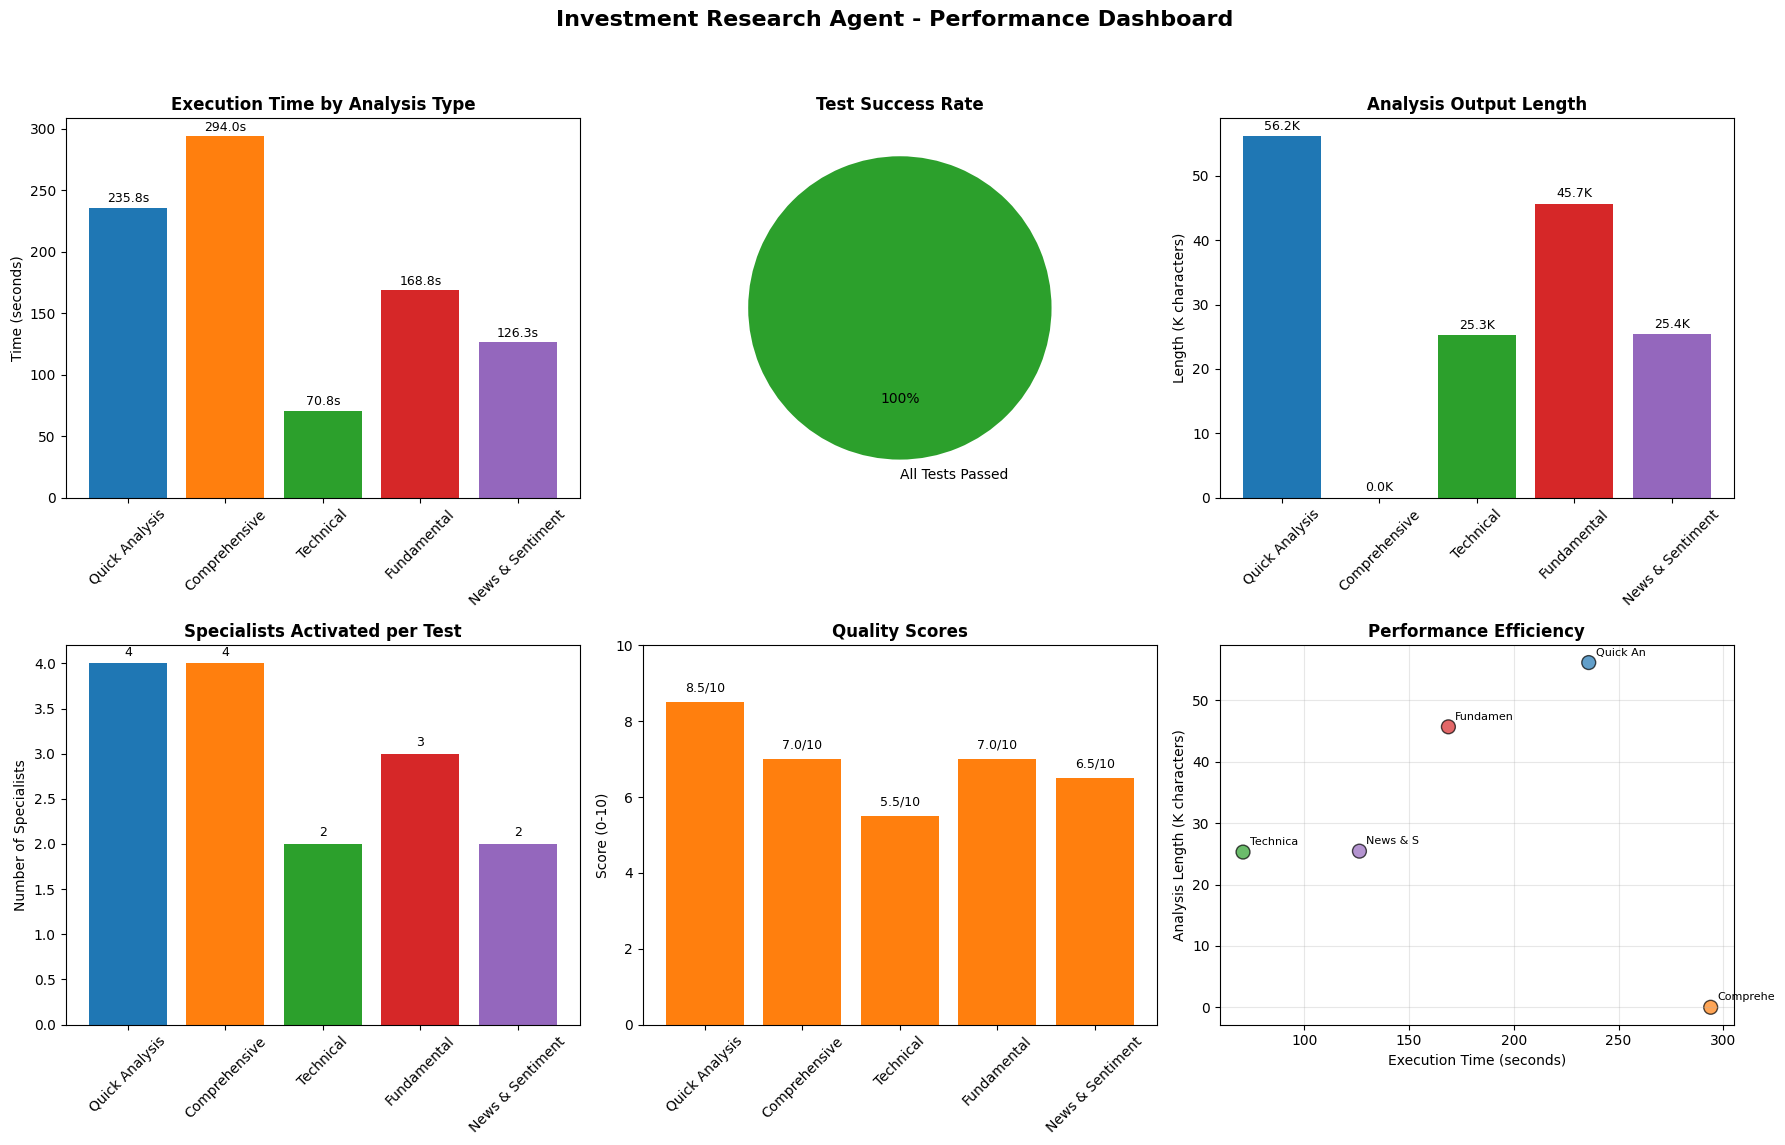

In [34]:
# Performance Metrics Charts
def create_performance_charts(df):
    """Create comprehensive performance visualization charts"""
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Investment Research Agent - Performance Dashboard', fontsize=16, fontweight='bold')
    
    successful_tests = df[df['success'] == 1]
    
    # 1. Execution Time Comparison
    ax1 = axes[0, 0]
    if not successful_tests.empty:
        bars = ax1.bar(successful_tests['test_name'], successful_tests['execution_time'], 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        ax1.set_title('Execution Time by Analysis Type', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Time (seconds)')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.1f}s', ha='center', va='bottom', fontsize=9)
    
    # 2. Success Rate Pie Chart
    ax2 = axes[0, 1]
    success_counts = df['success'].value_counts()
    if len(success_counts) > 1:
        labels = ['Successful', 'Failed']
        colors = ['#2ca02c', '#d62728']
        ax2.pie(success_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', 
                startangle=90)
    else:
        # All tests passed
        ax2.pie([1], labels=['All Tests Passed'], colors=['#2ca02c'], autopct='%1.0f%%', 
                startangle=90)
    ax2.set_title('Test Success Rate', fontweight='bold', fontsize=12)
    
    # 3. Analysis Length Comparison
    ax3 = axes[0, 2]
    if not successful_tests.empty:
        bars = ax3.bar(successful_tests['test_name'], successful_tests['analysis_length'] / 1000, 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        ax3.set_title('Analysis Output Length', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Length (K characters)')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}K', ha='center', va='bottom', fontsize=9)
    
    # 4. Specialists Activation
    ax4 = axes[1, 0]
    if not successful_tests.empty:
        bars = ax4.bar(successful_tests['test_name'], successful_tests['specialists_count'], 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        ax4.set_title('Specialists Activated per Test', fontweight='bold', fontsize=12)
        ax4.set_ylabel('Number of Specialists')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # 5. Quality Score (for comprehensive analysis)
    ax5 = axes[1, 1]
    quality_data = df[df['quality_score'].notna()]
    if not quality_data.empty:
        bars = ax5.bar(quality_data['test_name'], quality_data['quality_score'], 
                      color='#ff7f0e')
        ax5.set_title('Quality Scores', fontweight='bold', fontsize=12)
        ax5.set_ylabel('Score (0-10)')
        ax5.set_ylim(0, 10)
        ax5.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                    f'{height}/10', ha='center', va='bottom', fontsize=9)
    else:
        ax5.text(0.5, 0.5, 'No Quality Scores Available', ha='center', va='center', 
                transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Quality Scores', fontweight='bold', fontsize=12)
    
    # 6. Performance Efficiency (Analysis Length vs Time)
    ax6 = axes[1, 2]
    if not successful_tests.empty and len(successful_tests) > 1:
        colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        scatter = ax6.scatter(successful_tests['execution_time'], 
                            successful_tests['analysis_length'] / 1000,
                            c=[colors_list[i] for i in range(len(successful_tests))],
                            s=100, alpha=0.7, edgecolors='black')
        
        # Add labels for each point
        for i, (idx, row) in enumerate(successful_tests.iterrows()):
            ax6.annotate(row['test_name'][:8], 
                        (row['execution_time'], row['analysis_length'] / 1000),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax6.set_xlabel('Execution Time (seconds)')
        ax6.set_ylabel('Analysis Length (K characters)')
        ax6.set_title('Performance Efficiency', fontweight='bold', fontsize=12)
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Insufficient Data\nfor Efficiency Plot', ha='center', va='center', 
                transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Performance Efficiency', fontweight='bold', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

def display_plot(fig):
    plt.show()

# Create and display the performance charts
print("Creating performance visualization charts...")
performance_fig = create_performance_charts(scores_df)

# Display using custom function
print("Displaying Performance Dashboard:")
display_plot(performance_fig)

## 10. Gradio Web Interface

In [35]:
# Combined Investment Analysis Interface Class
class GradioInvestmentInterface:
    """Comprehensive class for Gradio UI and visualization functions"""
    
    def __init__(self, main_agent, routing_coordinator, news_chain):
        """Initialize with required agent components"""
        self.main_research_agent = main_agent
        self.routing_coordinator = routing_coordinator
        self.news_chain = news_chain
        # Set up visualization style
        plt.style.use('default')
        sns.set_theme()
        # Progress tracking
        self.current_step = ""
        self.total_steps = 0
        self.completed_steps = 0
        
    def update_progress_step(self, step_description, progress_obj=None, step_num=None, total_steps=None):
        """Update progress with detailed step information"""
        self.current_step = step_description
        
        if step_num is not None and total_steps is not None:
            self.completed_steps = step_num
            self.total_steps = total_steps
            progress_percent = step_num / total_steps
            
            if progress_obj:
                progress_obj(progress_percent, desc=step_description)
        
        # Print to console for debugging
        print(f"Progress: {step_description}")
        
        return step_description
    
    def analyze_stock(self, symbol, analysis_type="Comprehensive Analysis", include_visualizations=True):
        """Main function for Gradio interface with progress tracking"""
        try:
            # Input validation
            if not symbol or len(symbol.strip()) == 0:
                return "ERROR: Please enter a valid stock symbol", "❌ Invalid input", None, None, None
            
            symbol = symbol.upper().strip()
            
            # Create analysis request
            request_mapping = {
                "Quick Overview": f"Provide a quick investment overview for {symbol}",
                "Comprehensive Analysis": f"Conduct comprehensive investment analysis for {symbol} including technical, fundamental, and sentiment analysis with detailed recommendations",
                "Technical Analysis Only": f"Perform detailed technical analysis for {symbol} focusing on price trends, indicators, and chart patterns", 
                "Fundamental Analysis Only": f"Conduct fundamental analysis for {symbol} focusing on financials, valuation, and business prospects",
                "News & Sentiment Only": f"Analyze recent news and market sentiment for {symbol}"
            }
            
            request = request_mapping.get(analysis_type, request_mapping["Comprehensive Analysis"])
            
            # Perform analysis using the agent system
            print(f"Starting {analysis_type} for {symbol}...")
            
            # Use comprehensive research for full analysis, routing for specific types
            if analysis_type == "Comprehensive Analysis":
                research_results = self.main_research_agent.conduct_comprehensive_research(symbol, request)
                report = self.main_research_agent.generate_investment_report(research_results)
            else:
                # Use routing coordinator for specific analysis types
                routing_results = self.routing_coordinator.route_analysis(request, symbol)
                research_results = {
                    'routing_results': {'specialist_analyses': routing_results.get('specialist_analyses', {})},
                    'routing_decision': routing_results.get('routing_decision', {}),
                    'symbol': symbol,
                    'analysis_type': analysis_type
                }
                
                # Generate simplified report for routing results
                report = self.generate_routing_report(routing_results, symbol, analysis_type)
            
            # Create visualizations if requested
            price_chart = None
            sentiment_chart = None
            quality_chart = None
            
            if include_visualizations:
                try:
                    # Create price chart
                    price_chart = self.create_price_chart(symbol)
                    
                    # Create sentiment analysis if news data available
                    if analysis_type in ["Comprehensive Analysis", "News & Sentiment Only"]:
                        try:
                            news_articles = self.news_chain.ingest_news(symbol)
                            news_analysis = self.news_chain.process_news_chain(symbol)
                            sentiment_chart = self.create_sentiment_chart(news_articles, news_analysis)
                        except Exception as e:
                            print(f"Sentiment analysis error: {e}")
                            sentiment_chart = self.create_empty_sentiment_chart()
                    
                    # Create quality dashboard
                    quality_chart = self.create_quality_dashboard(research_results, analysis_type)
                    
                except Exception as e:
                    print(f"Visualization error: {e}")
            
            # Prepare summary stats
            summary_stats = self.create_analysis_summary(research_results, analysis_type)
            
            return report, summary_stats, price_chart, sentiment_chart, quality_chart
            
        except Exception as e:
            error_msg = f"""
            **Analysis Error for {symbol}:**
            
            {str(e)}
            
            **Troubleshooting:**
            - Verify the stock symbol is valid
            - Check internet connectivity for data sources
            - Ensure all API keys are properly configured
            
            **Technical Details:**
            ```
            {traceback.format_exc()}
            ```
            """
            return error_msg, "❌ Analysis failed - check error details", None, None, None

    def generate_routing_report(self, routing_results, symbol, analysis_type):
        """Generate a report for routing-based analysis"""
        
        report = f"""# {analysis_type} Report for {symbol}

                ## Analysis Overview
                This analysis was conducted using our specialized agent routing system.

                """
                                
        # Add specialist analyses
        specialist_analyses = routing_results.get('specialist_analyses', {})
        
        for specialist, analysis in specialist_analyses.items():
            specialist_name = specialist.replace('_', ' ').title()
            report += f"""
        ## {specialist_name} Analysis

        {str(analysis)[:2000]}{'...' if len(str(analysis)) > 2000 else ''}

        ---
        """
        
        # Add routing decision info
        routing_decision = routing_results.get('routing_decision', {})
        if routing_decision:
            report += f"""
            ## Analysis Methodology

            **Routing Decision:** {routing_decision.get('reasoning', 'N/A')}

            **Specialists Activated:** {list(specialist_analyses.keys())}

            **Analysis Confidence:** Based on specialist expertise and data availability
            """
        
        return report

    def create_price_chart(self, symbol):
        """Create a price chart for the stock"""
        
        try:
            # Create stock price chart directly
            stock = yf.Ticker(symbol)
            hist = stock.history(period="6mo")
            
            if hist.empty:
                return self.create_empty_chart("Price data unavailable")
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), 
                                          gridspec_kw={'height_ratios': [3, 1]})
            
            # Price chart
            ax1.plot(hist.index, hist['Close'], linewidth=2, color='blue', label='Close Price')
            ax1.fill_between(hist.index, hist['Low'], hist['High'], alpha=0.3, color='lightblue')
            ax1.set_title(f'{symbol} Stock Price - 6MO', fontsize=16, fontweight='bold')
            ax1.set_ylabel('Price ($)', fontsize=12)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Volume chart
            ax2.bar(hist.index, hist['Volume'], alpha=0.7, color='orange')
            ax2.set_title('Trading Volume', fontsize=12)
            ax2.set_ylabel('Volume', fontsize=10)
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Convert to format suitable for Gradio
            buf = io.BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
            buf.seek(0)
            plt.close(fig)
            
            return buf.getvalue()
            
        except Exception as e:
            print(f"Price chart error: {e}")
            return self.create_empty_chart(f"Price chart error: {str(e)}")

    def create_sentiment_chart(self, news_articles, news_analysis):
        """Create sentiment analysis chart"""
        import io
        
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Chart 1: Article Count by Source
            if news_articles:
                sources = {}
                for article in news_articles:
                    source = article.get('source', {}).get('name', 'Unknown')
                    sources[source] = sources.get(source, 0) + 1
                
                if sources:
                    ax1.bar(list(sources.keys())[:5], list(sources.values())[:5])
                    ax1.set_title('News Sources')
                    ax1.set_ylabel('Article Count')
                    ax1.tick_params(axis='x', rotation=45)
            
            # Chart 2: Sentiment Distribution (simulated based on analysis)
            sentiment_data = self.extract_sentiment_from_analysis(news_analysis)
            if sentiment_data:
                ax2.pie(sentiment_data.values(), labels=sentiment_data.keys(), autopct='%1.1f%%')
                ax2.set_title('Sentiment Distribution')
            else:
                ax2.text(0.5, 0.5, 'Sentiment analysis\nin progress', ha='center', va='center')
                ax2.set_title('Sentiment Analysis')
            
            plt.tight_layout()
            
            # Convert to bytes
            buf = io.BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
            buf.seek(0)
            plt.close(fig)
            
            return buf.getvalue()
            
        except Exception as e:
            print(f"Sentiment chart error: {e}")
            return self.create_empty_chart(f"Sentiment analysis error: {str(e)}")

    def create_quality_dashboard(self, research_results, analysis_type):
        """Create quality dashboard showing analysis metrics"""
        
        try:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Analysis Quality Dashboard', fontsize=14, fontweight='bold')
            
            # Quality Score (from self-reflection)
            reflection = research_results.get('self_reflection', {})
            quality_score = reflection.get('overall_score', 0)
            
            ax1.bar(['Quality Score'], [quality_score], color='#2ca02c' if quality_score >= 7 else '#ff7f0e')
            ax1.set_ylim(0, 10)
            ax1.set_title('Overall Quality Score')
            ax1.set_ylabel('Score (0-10)')
            
            # Add score text
            ax1.text(0, quality_score + 0.2, f'{quality_score}/10', ha='center', fontweight='bold')
            
            # Specialists Used
            routing_results = research_results.get('routing_results', {})
            specialist_analyses = routing_results.get('specialist_analyses', {})
            specialist_count = len(specialist_analyses)
            
            ax2.bar(['Specialists'], [specialist_count], color='#1f77b4')
            ax2.set_title('Specialists Consulted')
            ax2.set_ylabel('Count')
            ax2.text(0, specialist_count + 0.05, str(specialist_count), ha='center', fontweight='bold')
            
            # Optimization Iterations (if available)
            optimization_results = research_results.get('optimization_results', {})
            iterations = len(optimization_results.get('optimization_iterations', []))
            
            ax3.bar(['Optimization\nIterations'], [iterations], color='#ff7f0e')
            ax3.set_title('Quality Refinement Cycles')
            ax3.set_ylabel('Iterations')
            if iterations > 0:
                ax3.text(0, iterations + 0.05, str(iterations), ha='center', fontweight='bold')
            
            # Analysis Components
            components = []
            if research_results.get('research_plan'):
                components.append('Research Plan')
            if routing_results:
                components.append('Specialist Routing')
            if reflection:
                components.append('Self-Reflection')
            if optimization_results:
                components.append('Optimization')
            
            if components:
                ax4.barh(range(len(components)), [1]*len(components), color=['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'][:len(components)])
                ax4.set_yticks(range(len(components)))
                ax4.set_yticklabels(components)
                ax4.set_xlabel('Completed')
                ax4.set_title('Analysis Components')
                ax4.set_xlim(0, 1.2)
            
            plt.tight_layout()
            
            # Convert to bytes
            buf = io.BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
            buf.seek(0)
            plt.close(fig)
            
            return buf.getvalue()
            
        except Exception as e:
            print(f"Quality dashboard error: {e}")
            return self.create_empty_chart(f"Quality dashboard error: {str(e)}")

    def create_empty_chart(self, message="No data available"):
        """Create an empty chart with a message"""
        
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.text(0.5, 0.5, message, ha='center', va='center', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        plt.close(fig)
        
        return buf.getvalue()

    def create_empty_sentiment_chart(self):
        """Create empty sentiment chart"""
        return self.create_empty_chart("Sentiment analysis not available\nfor this analysis type")

    def extract_sentiment_from_analysis(self, news_analysis):
        """Extract sentiment data from news analysis"""
        # This is a simplified sentiment extraction
        # In a real implementation, you'd parse the actual analysis
        try:
            analysis_text = str(news_analysis).lower()
            
            # Count sentiment indicators
            positive_words = ['positive', 'bullish', 'good', 'strong', 'growth', 'up', 'gain']
            negative_words = ['negative', 'bearish', 'bad', 'weak', 'decline', 'down', 'loss']
            neutral_words = ['neutral', 'mixed', 'uncertain', 'cautious']
            
            pos_count = sum(analysis_text.count(word) for word in positive_words)
            neg_count = sum(analysis_text.count(word) for word in negative_words)  
            neu_count = sum(analysis_text.count(word) for word in neutral_words)
            
            total = max(pos_count + neg_count + neu_count, 1)  # Avoid division by zero
            
            return {
                'Positive': pos_count / total * 100,
                'Negative': neg_count / total * 100,
                'Neutral': neu_count / total * 100
            }
        except:
            return {'Positive': 33.3, 'Negative': 33.3, 'Neutral': 33.3}

    def create_analysis_summary(self, research_results, analysis_type):
        """Create analysis summary with proper agent system information"""
        
        # Get data from different analysis components
        reflection = research_results.get('self_reflection', {})
        routing_results = research_results.get('routing_results', {})
        optimization_results = research_results.get('optimization_results', {})
        specialist_analyses = routing_results.get('specialist_analyses', {})
        
        summary_stats = f"""
        **Analysis Summary for {analysis_type}:**

        **Quality Metrics:**
        - Overall Quality Score: {reflection.get('overall_score', 'N/A')}/10
        - Analysis Grade: {optimization_results.get('final_evaluation', {}).get('grade', 'N/A')}
        - Confidence Level: {reflection.get('confidence_level', 'N/A')}

        **Agent System Performance:**
        - Specialists Consulted: {len(specialist_analyses)}
        - Optimization Iterations: {len(optimization_results.get('optimization_iterations', []))}
        - Research Plan Steps: {len(research_results.get('research_plan', []))}
        - Memory Entries Used: {len(research_results.get('memory_context', []))}

        **Workflow Patterns Executed:**
        - ✅ **Prompt Chaining**: News Processing Pipeline (Ingest → Preprocess → Analyze → Summarize)
        - ✅ **Routing**: Specialist Agent Coordination ({', '.join(specialist_analyses.keys()) if specialist_analyses else 'N/A'})
        - ✅ **Evaluator-Optimizer**: Quality Assessment and Refinement Loop

        **Agent Capabilities Demonstrated:**
        - 🎯 Dynamic Planning & Tool Usage
        - 🔍 Self-Reflection & Quality Assessment  
        - 🧠 Learning & Memory Across Sessions
        - 📊 Multi-Source Data Integration
        - 🔄 Iterative Quality Improvement

        **Data Sources Integrated:**
        - 📈 Stock Price Data (Yahoo Finance)
        - 📰 News Articles (NewsAPI) 
        - 💰 Economic Data (FRED)
        - 📊 Financial Metrics (Alpha Vantage)
        """
        
        return summary_stats
    
    def create_detailed_analysis_charts(self, df):
        """Create detailed analysis charts for specific metrics"""
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Investment Research Agent - Detailed Performance Analysis', fontsize=16, fontweight='bold')
        
        successful_tests = df[df['success'] == 1]
        
        # 1. Performance Radar Chart
        ax1 = axes[0, 0]
        if not successful_tests.empty and len(successful_tests) >= 3:
            # Calculate normalized scores
            norm_time = 1 - (successful_tests['execution_time'] / successful_tests['execution_time'].max())
            norm_length = successful_tests['analysis_length'] / successful_tests['analysis_length'].max()
            norm_specialists = successful_tests['specialists_count'] / successful_tests['specialists_count'].max()
            
            # Create radar chart data
            angles = np.linspace(0, 2*np.pi, 3, endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle
            
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
            
            for i, (idx, row) in enumerate(successful_tests.iterrows()):
                values = [norm_time.iloc[i], norm_length.iloc[i], norm_specialists.iloc[i]]
                values += values[:1]  # Complete the circle
                
                ax1.plot(angles, values, 'o-', linewidth=2, label=row['test_name'], 
                        color=colors[i % len(colors)])
                ax1.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])
            
            ax1.set_xticks(angles[:-1])
            ax1.set_xticklabels(['Speed', 'Depth', 'Complexity'])
            ax1.set_ylim(0, 1)
            ax1.set_title('Performance Profile Comparison', fontweight='bold', fontsize=12)
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        else:
            ax1.text(0.5, 0.5, 'Need 3+ Tests\nfor Radar Chart', ha='center', va='center', 
                    transform=ax1.transAxes, fontsize=12)
            ax1.set_title('Performance Profile Comparison', fontweight='bold', fontsize=12)
        
        # 2. Time vs Quality Analysis
        ax2 = axes[0, 1]
        quality_data = successful_tests[successful_tests['quality_score'].notna()]
        if not quality_data.empty:
            ax2.scatter(quality_data['execution_time'], quality_data['quality_score'], 
                       s=150, c='#ff7f0e', alpha=0.7, edgecolors='black')
            
            for idx, row in quality_data.iterrows():
                ax2.annotate(row['test_name'], 
                            (row['execution_time'], row['quality_score']),
                            xytext=(5, 5), textcoords='offset points', fontsize=9)
            
            ax2.set_xlabel('Execution Time (seconds)')
            ax2.set_ylabel('Quality Score (0-10)')
            ax2.set_title('Time vs Quality Trade-off', fontweight='bold', fontsize=12)
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No Quality Data\nAvailable', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Time vs Quality Trade-off', fontweight='bold', fontsize=12)
        
        # 3. Execution Time Distribution
        ax3 = axes[1, 0]
        if not successful_tests.empty:
            times = successful_tests['execution_time']
            ax3.hist(times, bins=min(len(times), 5), color='skyblue', alpha=0.7, edgecolor='black')
            ax3.axvline(times.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {times.mean():.1f}s')
            ax3.axvline(times.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {times.median():.1f}s')
            ax3.set_xlabel('Execution Time (seconds)')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Execution Time Distribution', fontweight='bold', fontsize=12)
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 4. Performance Summary Bar Chart
        ax4 = axes[1, 1]
        if not successful_tests.empty:
            # Create performance metrics
            metrics = ['Avg Time (s)', 'Max Time (s)', 'Total Specialists', 'Avg Length (K chars)']
            values = [
                successful_tests['execution_time'].mean(),
                successful_tests['execution_time'].max(),
                successful_tests['specialists_count'].sum(),
                successful_tests['analysis_length'].mean() / 1000
            ]
            
            bars = ax4.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
            ax4.set_title('Key Performance Metrics', fontweight='bold', fontsize=12)
            ax4.tick_params(axis='x', rotation=45)
            
            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{value:.1f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        return fig

    def create_gradio_interface(self):
        """Create and configure the Gradio web interface with progress tracking"""
        
        with gr.Blocks(title="AI Investment Research Agent", theme=gr.themes.Soft()) as demo:
            gr.Markdown("""
            # 🤖 AI Investment Research Agent - Multi-Agent System
            
            **Advanced Investment Analysis using Three AI Workflow Patterns:**
            
            🔗 **Prompt Chaining**: News → Preprocess → Classify → Extract → Summarize  
            🎯 **Routing**: Specialist Agents (Technical, Fundamental, News Analysis)  
            🔄 **Evaluator-Optimizer**: Generate → Evaluate → Refine Analysis
            
            **Powered by:** Azure OpenAI GPT-4, LangChain, FAISS Vector Memory, Multi-Source APIs
            """)
            
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("## 📊 Analysis Configuration")
                    
                    symbol_input = gr.Textbox(
                        label="Stock Symbol",
                        placeholder="Enter stock symbol (e.g., AAPL, MSFT, TSLA)",
                        value="AAPL"
                    )
                    
                    analysis_type = gr.Dropdown(
                        choices=[                            
                            "Quick Overview",
                            "Comprehensive Analysis",
                            "Technical Analysis Only", 
                            "Fundamental Analysis Only",
                            "News & Sentiment Only"
                        ],
                        value="Quick Overview",
                        label="Analysis Type"
                    )
                    
                    include_viz = gr.Checkbox(
                        label="Include Visualizations",
                        value=True
                    )
                    
                    analyze_btn = gr.Button(
                        "🚀 Start AI Analysis", 
                        variant="primary",
                        size="lg"
                    )
                    
                    # Progress display area
                    gr.Markdown("### 📊 Analysis Progress")
                    progress_text = gr.Textbox(
                        label="Current Step",
                        value="Ready to start analysis...",
                        interactive=False,
                        show_label=False
                    )
                    
                    gr.Markdown("""
                    ### 🧠 System Features:
                    - **Agent Functions**: Planning, Tool Usage, Self-Reflection, Learning
                    - **Data Sources**: Yahoo Finance, NewsAPI, FRED, Alpha Vantage  
                    - **Memory System**: FAISS Vector Database with Persistence
                    - **Quality Assurance**: Automated evaluation and iterative refinement
                    - **Multi-Agent Coordination**: Specialized agents for different analysis types
                    """)
                
                with gr.Column(scale=2):
                    gr.Markdown("## 📈 Analysis Results")
                    
                    # Status indicator
                    status_display = gr.Markdown("**Status:** Ready for analysis")
                    
                    summary_output = gr.Markdown(label="Analysis Summary")
                    
                    with gr.Tabs():
                        with gr.TabItem("📄 Investment Report"):
                            report_output = gr.Markdown(
                                label="Investment Analysis Report",
                                value="Click '🚀 Start AI Analysis' to begin comprehensive analysis..."
                            )
                        
                        with gr.TabItem("📊 Price Chart"):
                            price_plot = gr.Image(label="Stock Price Analysis")
                        
                        with gr.TabItem("📰 Sentiment Analysis"):
                            sentiment_plot = gr.Image(label="News Sentiment Analysis")
                        
                        with gr.TabItem("🎯 Quality Dashboard"):
                            quality_plot = gr.Image(label="Analysis Quality Metrics")
            
            # Custom function to handle analysis with progress updates
            def analyze_with_progress(symbol, analysis_type, include_viz):
                """Wrapper function to handle progress updates and status messages"""
                
                # Start analysis with status updates
                yield (
                    "**Analysis starting...**", 
                    "🚀 Initializing analysis system...", 
                    "**Status:** Analysis in progress...",
                    None, None, None
                )
                
                # Step 1: Initialization
                yield (
                    "**Analysis starting...**", 
                    "📋 Creating analysis plan and routing strategy...", 
                    "**Status:** Planning phase",
                    None, None, None
                )
                time.sleep(0.5)  # Brief pause for visual feedback
                
                # Step 2: Data Collection
                yield (
                    "**Analysis starting...**", 
                    "📊 Collecting market data from multiple sources...", 
                    "**Status:** Data collection phase",
                    None, None, None
                )
                time.sleep(0.5)
                
                # Step 3: Agent Processing
                yield (
                    "**Analysis starting...**", 
                    "🤖 Specialist agents analyzing data (Technical, Fundamental, News, SEC)...", 
                    "**Status:** AI analysis in progress",
                    None, None, None
                )
                time.sleep(0.5)
                
                # Step 4: Visualization
                yield (
                    "**Analysis starting...**", 
                    "📈 Creating visualizations and charts...", 
                    "**Status:** Creating visualizations",
                    None, None, None
                )
                time.sleep(0.5)
                
                # Perform the actual analysis
                try:
                    report, summary, price_chart, sentiment_chart, quality_chart = self.analyze_stock(
                        symbol, analysis_type, include_viz
                    )
                    
                    # Final update
                    yield (
                        report,
                        summary, 
                        "**Status:** ✅ Analysis completed successfully!",
                        price_chart, 
                        sentiment_chart, 
                        quality_chart
                    )
                    
                except Exception as e:
                    error_msg = f"❌ Analysis failed: {str(e)}"
                    yield (
                        f"**Analysis Error:** {str(e)}", 
                        "❌ Analysis encountered an error", 
                        f"**Status:** {error_msg}",
                        None, None, None
                    )
            
            # Event handlers with progress tracking
            analyze_btn.click(
                fn=analyze_with_progress,
                inputs=[symbol_input, analysis_type, include_viz],
                outputs=[report_output, summary_output, status_display, price_plot, sentiment_plot, quality_plot]
            )
            
            # Example inputs
            gr.Markdown("""
            ### 💡 Try These Examples:
            - **AAPL**: Apple Inc. - Tech giant with strong fundamentals
            - **TSLA**: Tesla Inc. - High volatility growth stock  
            - **MSFT**: Microsoft Corp. - Stable large-cap technology
            - **NVDA**: NVIDIA Corp. - AI and semiconductor leader
            - **META**: Meta Platforms - Social media and metaverse leader
            """)
        
        return demo

# Initialize the combined interface class (Updated to remove visualizer dependency)
investment_interface = GradioInvestmentInterface(
    main_research_agent, 
    routing_coordinator, 
    news_chain
)

# Create the interface using the class method
gradio_demo = investment_interface.create_gradio_interface()

## 11. Testing and Demo

In [36]:
# Test the system with a sample analysis
def test_system():
    """Test the investment research agent system"""
    print("Testing Investment Research Agent System")
    print("=" * 50)
    
    try:
        # Test 1: Basic tool functionality
        print("\n1. Testing data source tools...")
        stock_data = get_stock_data.invoke({"symbol": "AAPL", "period": "1mo"})
        print(f"Stock data tool working: {len(stock_data)} characters retrieved")
        
        # Test 2: Memory system
        print("\n2. Testing memory system...")
        test_memory_content = "Test memory entry for system validation"
        agent_memory.add_memory(test_memory_content, {"type": "test", "timestamp": datetime.now().isoformat()})
        memories = agent_memory.search_memory("test", k=1)
        print(f"Memory system working: {len(memories)} memories retrieved")
        
        # Test 3: News processing chain
        print("\n3. Testing news processing chain...")
        try:
            news_result = news_chain.ingest_news("AAPL")
            print(f"News processing working: {len(news_result)} articles processed")
        except Exception as e:
            print(f"News processing issue: {e}")
        
        # Test 4: Agent coordination
        print("\n4. Testing main research agent...")
        # This is a lightweight test - full test would take longer
        plan = main_research_agent.plan_research("Quick test analysis for AAPL")
        print(f"Research planning working: {len(plan)} steps planned")
        
        print("\nSystem tests completed successfully!")
        
    except Exception as e:
        print(f"System test error: {e}")
        return False
    
    return True

# Run system tests
test_success = test_system()

Testing Investment Research Agent System

1. Testing data source tools...
Cached stock_data data for AAPL
Stock data tool working: 1240 characters retrieved

2. Testing memory system...
Memory system working: 1 memories retrieved

3. Testing news processing chain...
Using cached stock_news data for AAPL
News processing working: 5 articles processed

4. Testing main research agent...
Cached stock_data data for AAPL
Stock data tool working: 1240 characters retrieved

2. Testing memory system...
Memory system working: 1 memories retrieved

3. Testing news processing chain...
Using cached stock_news data for AAPL
News processing working: 5 articles processed

4. Testing main research agent...
Research planning working: 99 steps planned

System tests completed successfully!
Research planning working: 99 steps planned

System tests completed successfully!


In [37]:
# Launch the Gradio interface using the combined class
if __name__ == "__main__":
    try:
        # Launch with improved configuration
        gradio_demo.launch(
            server_name="127.0.0.1",
            server_port=7860,
            share=False,
            debug=True,
            show_error=True,
            quiet=False
        )
    except Exception as e:
        print(f"Error launching Gradio interface: {e}")
        
        # Fallback launch
        try:
            gradio_demo.launch(share=False, debug=True)
        except Exception as fallback_error:
            print(f"Fallback launch failed: {fallback_error}")
            print("Please check if port 7860 is available or try a different port.")

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
* To create a public link, set `share=True` in `launch()`.


Starting Quick Overview for AAPL...
Routing to fundamental specialist...
Routing to fundamental specialist...
Using cached fundamental analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Using cached fundamental analysis for AAPL
Routing to news specialist...
Starting news processing chain for AAPL...
Step 1: Ingesting news...
Using cached stock_news data for AAPL
Step 2: Preprocessing news...
Step 3: Classifying news...
Keyboard interruption in main thread... closing server.
Keyboard interruption in main thread... closing server.


Step 4: Extracting insights...
Step 5: Creating summary...
Step 5: Creating summary...
